In [17]:
#system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz


# misc
import warnings

import glob

##
import pytz
import datetime as dt
import math
import seaborn as sns


import pickle

In [18]:

import biosppy
from biosppy import storage
from biosppy.signals import ecg


# misc
import warnings

#signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

## Read and manipulate Psychopy dataframe

In [19]:
def read_manipulate_psychopy(psychopy_path):
    
    psychopy_df = pd.read_csv(psychopy_path)
    col_list = [col for col in psychopy_df.columns if col.endswith('_ts')]
    #col_list.insert(0, "Reference_time")
    psychopy_df_selected = psychopy_df[col_list]
    
    return psychopy_df_selected


def get_nonNan_list_psychopy(psychopy_df, col_name):
    
    
    selected_vals=[val for val in psychopy_df[col_name].to_list() if not(math.isnan(val))]
    
    return selected_vals


def sel_pre_analysis_file(events_path_list):
    
    for sel_event_path in events_path_list:
        fol_path, file_name_ii=os.path.split(sel_event_path)
        if "trigger" in file_name_ii:
            events_with_trigger= sel_event_path
            
            
    return sel_event_path
    

## Read, manipulate and slice Shimmer dataframe

In [20]:
#######---------------------------------------------------
###### ------------------Shimmer--------------------------
###----------------------------------------------------------


def read_shimmer_sensor(sensor_file_path):
    
    shimmer_df = pd.read_csv(sensor_file_path, sep='\t', low_memory=False)
    shimmer_df = shimmer_df.reset_index()
    shimmer_df.columns = shimmer_df.iloc[0]
    shimmer_df.drop([0, 1], axis=0, inplace=True)
    shimmer_df=shimmer_df.reset_index(drop=True)
    
    return shimmer_df

def standardize_timestamps_shimmer(shimmer_df, timestamps_col_name):
    
    timesstamps_list = shimmer_df[timestamps_col_name].to_list()
    new_timestamps_list = [float(val)/1000 for val in  timesstamps_list]
    
    shimmer_df[timestamps_col_name] = new_timestamps_list
    
    return shimmer_df



def get_offset_timestamp(timestamp, offset_mins):
    
    time_zone = 'Europe/Berlin'
    tz = pytz.timezone(time_zone)
    local_time = dt.datetime.fromtimestamp(timestamp, tz)
    time_change = dt.timedelta(minutes=offset_mins)
    new_time = local_time + time_change
    new_timestamp =  dt.datetime.timestamp(new_time)
    return new_timestamp

def get_list_timestamp_interest(starting_timestamp, list_offset_mins):
    
    starting_timestamp_list=[]
    
    for offset_min in list_offset_mins:
        starting_timestamp_list.append(starting_timestamp)
        timestamp_offset = get_offset_timestamp(starting_timestamp, offset_min)
        starting_timestamp = timestamp_offset  
     
    
    #starting_timestamp_list = sorted(starting_timestamp_list, key = lambda x:float(x))
    return starting_timestamp_list
        
        

def slice_df_wrt_timestamps(df, start_timestamp, end_timestamp, timestamps_col):
    
    sliced_df=df[(df[timestamps_col]>= start_timestamp) & (df[timestamps_col] <= end_timestamp)]
    
    return sliced_df


def from_str_to_float(str_list):
    #float(recovery_onset_str_timestamps[0][1:-1])
    
    float_array =[float(val[1:-1]) for val in str_list]
    
    return float_array

def col_from_str_float (df, col_name):
    
    str_list = df[col_name].values
    
    float_array =[float(val) for val in str_list]
    
    df[col_name] = float_array
    
    return df

## Time Domain HRV

In [21]:
def detect_peaks(ecg_signal, threshold=0.3, qrs_filter=None):
    '''
    Peak detection algorithm using cross corrrelation and threshold 
    '''
    if qrs_filter is None:
        # create default qrs filter, which is just a part of the sine function
        t = np.linspace(1.5 * np.pi, 3.5 * np.pi, 15)
        qrs_filter = np.sin(t)
    
    # normalize data
    ecg_signal = (ecg_signal - ecg_signal.mean()) / ecg_signal.std()

    # calculate cross correlation
    similarity = np.correlate(ecg_signal, qrs_filter, mode="same")
    similarity = similarity / np.max(similarity)

    # return peaks (values in ms) using threshold
    return ecg_signal[similarity > threshold].index, similarity



def group_peaks(p, threshold=5):
    '''
    The peak detection algorithm finds multiple peaks for each QRS complex. 
    Here we group collections of peaks that are very near (within threshold) and we take the median index 
    '''
    # initialize output
    output = np.empty(0)

    # label groups of sample that belong to the same peak
    peak_groups, num_groups = label(np.diff(p) < threshold)

    # iterate through groups and take the mean as peak index
    for i in np.unique(peak_groups)[1:]:
        peak_group = p[np.where(peak_groups == i)]
        output = np.append(output, int(np.median(peak_group)))
        
        
    #output = int(output)
    return output

def from_rr_ind_2_msec(r_peaks_ind, sampling_freq = 256):
    
    # RR-intervals are the differences between successive peaks
    r_peaks_sec = r_peaks_ind*1/sampling_freq
    r_peaks_msec = r_peaks_sec*1000

    r_peaks_diff_msec=np.diff(r_peaks_msec)
    
    return r_peaks_diff_msec
    
    
    
    
    

def remove_outliers_rri(r_peaks_diff_msec, sampling_freq = 256, outlier_std = 1.5):
    
    # RR-intervals are the differences between successive peaks
    #r_peaks_sec = r_peaks*1/sampling_freq
    #r_peaks_msec = r_peaks_sec*1000

    #r_peaks_diff=np.diff(r_peaks_msec)
    
    rr_corrected = r_peaks_diff_msec.copy()

    rr_corrected[np.abs(zscore(r_peaks_diff_msec)) > outlier_std] = np.median(r_peaks_diff_msec)
    
    return rr_corrected
    


def get_plot_ranges(start=10, end=20, n=5):
    '''
    Make an iterator that divides into n or n+1 ranges. 
    - if end-start is divisible by steps, return n ranges
    - if end-start is not divisible by steps, return n+1 ranges, where the last range is smaller and ends at n
    
    # Example:
    >> list(get_plot_ranges())
    >> [(0.0, 3.0), (3.0, 6.0), (6.0, 9.0)]

    '''
    distance = end - start
    for i in np.arange(start, end, np.floor(distance/n)):
        yield (int(i), int(np.minimum(end, np.floor(distance/n) + i)))
        
        
        
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## Plot raw and filtered ECG

In [39]:
def plot_ecg_wf(sliced_ecg_df,r_peaks, time_offset, dest_fol_path, fig_name,  raw_data_col_name="ecg", 
                filtered_data_col_name="filtered", nr_plots=3, 
                fig_title_raw = "Raw ECG", fig_title_filtered = "Filtered ECG"):    
    
    
    starting_index_slcide_df= sliced_ecg_df.index[0]
    sampfrom = starting_index_slcide_df
    sampto = starting_index_slcide_df+256*time_offset*60
    
    rr_interval_cumm = []
    for start, stop in get_plot_ranges(sampfrom, sampto, nr_plots):
        print(start)
        print(stop)
        
        # get sliced data of ECG
        #cond_slice = (sliced_ecg_df.index>= start) & (sliced_ecg_df.index <= stop)
        #sliced_ecg_hrv =sliced_ecg_df.filtered[cond_slice]
        
        sliced_ecg_hrv = sliced_ecg_df[filtered_data_col_name][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        sliced_ecg_raw = sliced_ecg_df[raw_data_col_name][(sliced_ecg_df.index >= start) & (sliced_ecg_df.index<= stop)]
        
        
        r_peaks_selected = [r_p for r_p in r_peaks if r_p >= start and r_p <= stop]
        
        fig_ecg=plt.figure(figsize=(20, 15))

        plt.subplot(211)
        plt.title(fig_title_raw)
        plt.plot(sliced_ecg_raw, label="ECG", color="#51A6D8", linewidth=1)
        #plt.plot(sliced_ecg_hrv.index[start: stop], sliced_ecg_hrv, label="ECG", color="#51A6D8", linewidth=1)
        #plt.plot(r_peaks_selected, np.repeat(0.3, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
        plt.legend(loc="upper right")
        plt.xlabel("Time (milliseconds)")
        plt.ylabel("Amplitude (arbitrary unit)")

        plt.subplot(212)
        plt.title(fig_title_filtered)
        
        #plt.plot(ecg_slice.index, similarity, label="Similarity with QRS filter", color="olive", linewidth=1)
        plt.plot(sliced_ecg_hrv, label="Filtered ECG", color="olive", linewidth=1)
        plt.plot(r_peaks_selected, np.repeat(0.2, len(r_peaks_selected)), label="peaks", color="orange", marker="o", linestyle="None")
        plt.legend(loc="upper right")
        plt.xlabel("Time (milliseconds)")
        plt.ylabel("Similarity (normalized)")
        
        plt.show()
        plot_figure = []
        plot_figure = fig_name
        print(plot_figure)
        #print(plot_figure[0])
        fig_name = str(start) + "_" + str(stop) + "_" + plot_figure
        fig_path = os.path.join(dest_fol_path, fig_name)
        fig_ecg.savefig(fig_path,format='svg' )
        
        

### Plot mean and standard deviations

In [40]:
def plot_mean_std(mean_list, std_list, label_list, title_figure, y_label_fig):
    x_pos = np.arange(len(label_list))
    fig, ax = plt.subplots()
    ax.bar(x_pos, mean_list, yerr=std_list, align='center', alpha=0.5, capsize=10 )
    ax.set_ylabel(y_label_fig)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(label_list, rotation=45, ha='right', rotation_mode='anchor')
    #title_ax = "VP001_251023_Session1_Shimmer_FBA7_Calibrated_SD"
    ax.set_title(title_figure)
    ax.yaxis.grid(True)
    #plt.ylim(0, 1) 
    plt.tight_layout()
    plt.show()
    return fig

## Min-Max Normaliaztion

In [41]:
def min_max_norm(all_rr_one_list, all_rr_sublist):
    
    mean_norm_list =[]
    std_norm_list = []
    
    all_rr_one_list = np.array(all_rr_one_list)
    max_val = np.max(all_rr_one_list)
    min_val =np.min(all_rr_one_list)
    
    for sel_list in all_rr_sublist:
        
        sel_list_np = np.array(sel_list)
        
        range_list = max_val-min_val
        
        sel_lis_np_sub = sel_list_np - min_val
        
        sel_lis_norm= sel_lis_np_sub/range_list
        
        mean_norm = np.mean(sel_lis_norm)
        mean_norm_list.append(mean_norm)
        
        std_norm  = np.std(sel_lis_norm)   
        std_norm_list.append(std_norm)
        #print(mean_norm)
        #print(std_norm)
                
        
    return mean_norm_list, std_norm_list

In [42]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    #results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## Cummulative -------------------------------------

In [43]:
#data_dir_path = "/media/muhammad/d5e4618d-a960-4f0d-a521-1c804bbebbb4/dataset_sony_sam_2024/WP2"
data_dir_path = "D:/Datasets/DatasetSonySAM/WP2"
sub_dirs=next(os.walk(data_dir_path))[1]
sub_dirs=sorted(sub_dirs)

In [44]:
#dest_path = "/home/muhammad/Desktop/Datasets/dataset_sony_sam/Data_analysis_ECG/pkld_file_per_subject_per_task"
dest_path = "D:/Datasets/DatasetSonySAM/Results/svg"

psychopy_events_triggers_WP2_03_VEOQ.csv
pre_assesment
BASELINE DATA
0
25600


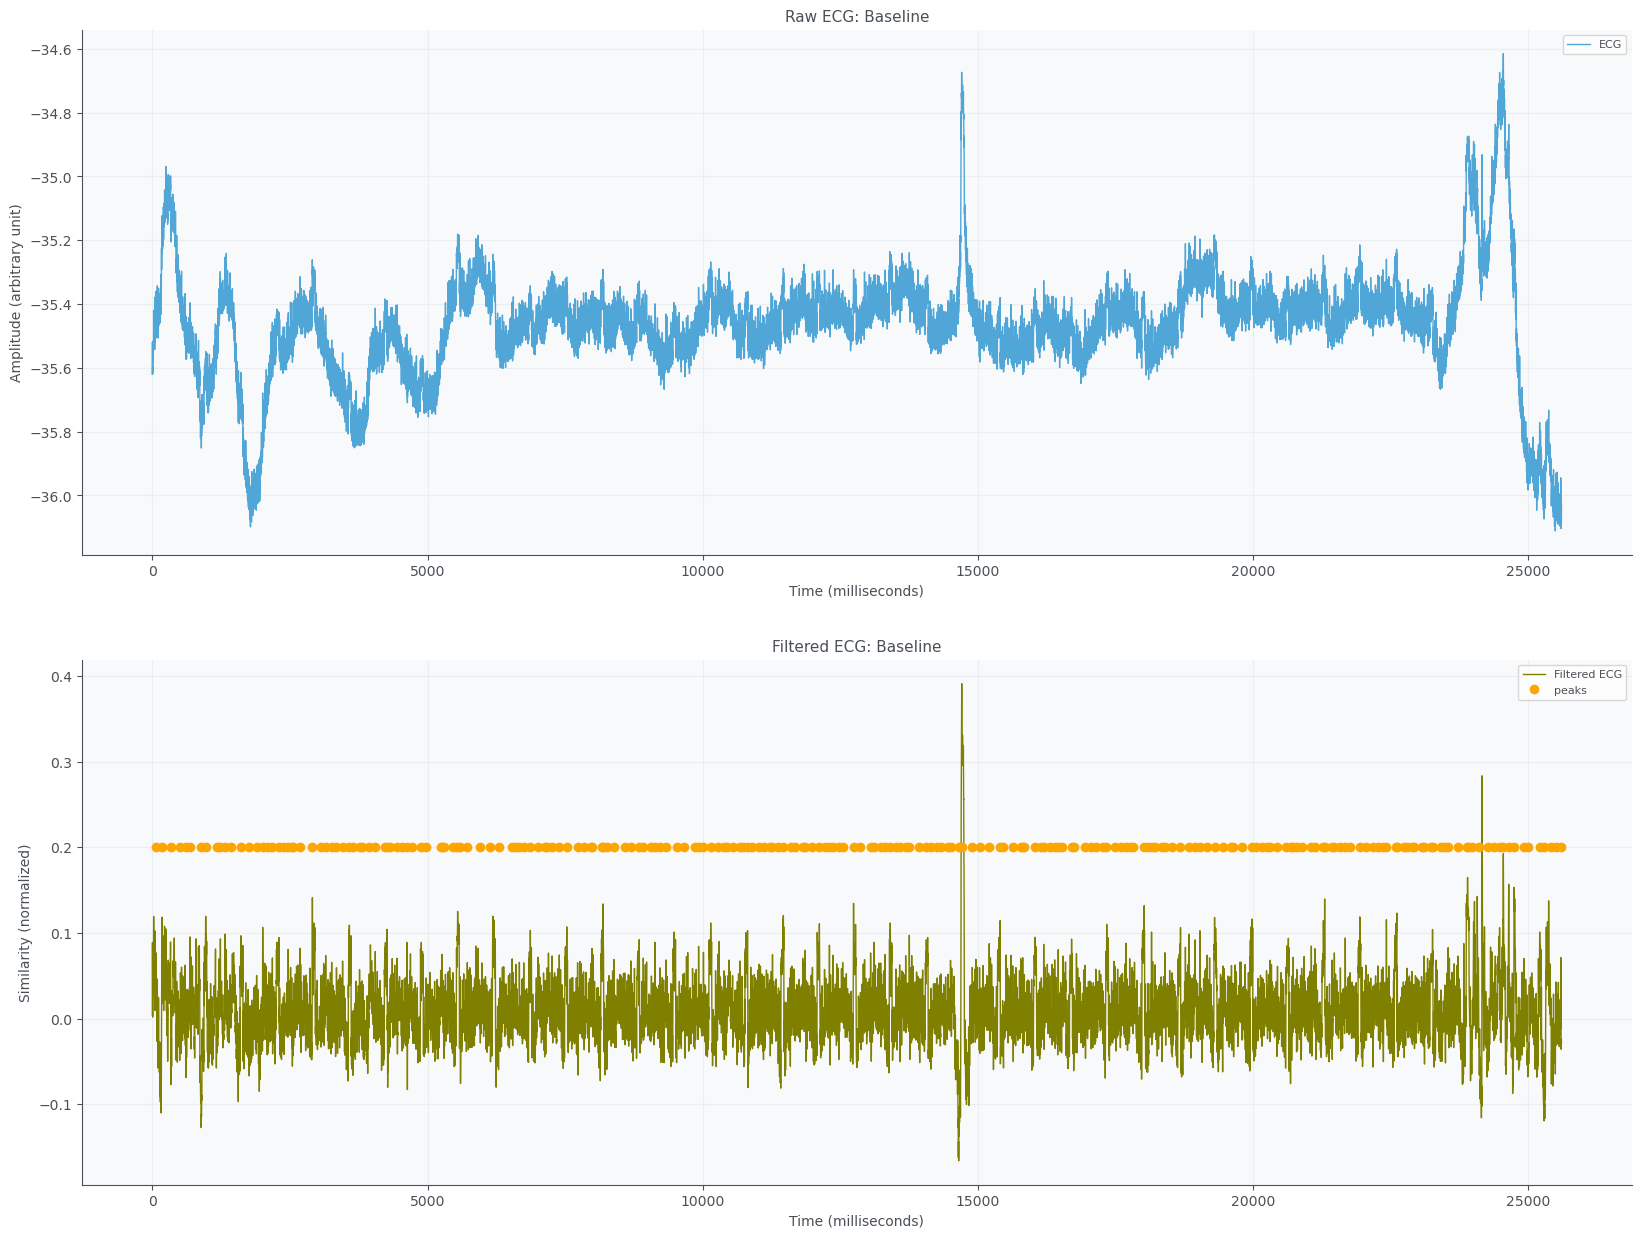

Baseline0.svg
25600
51200


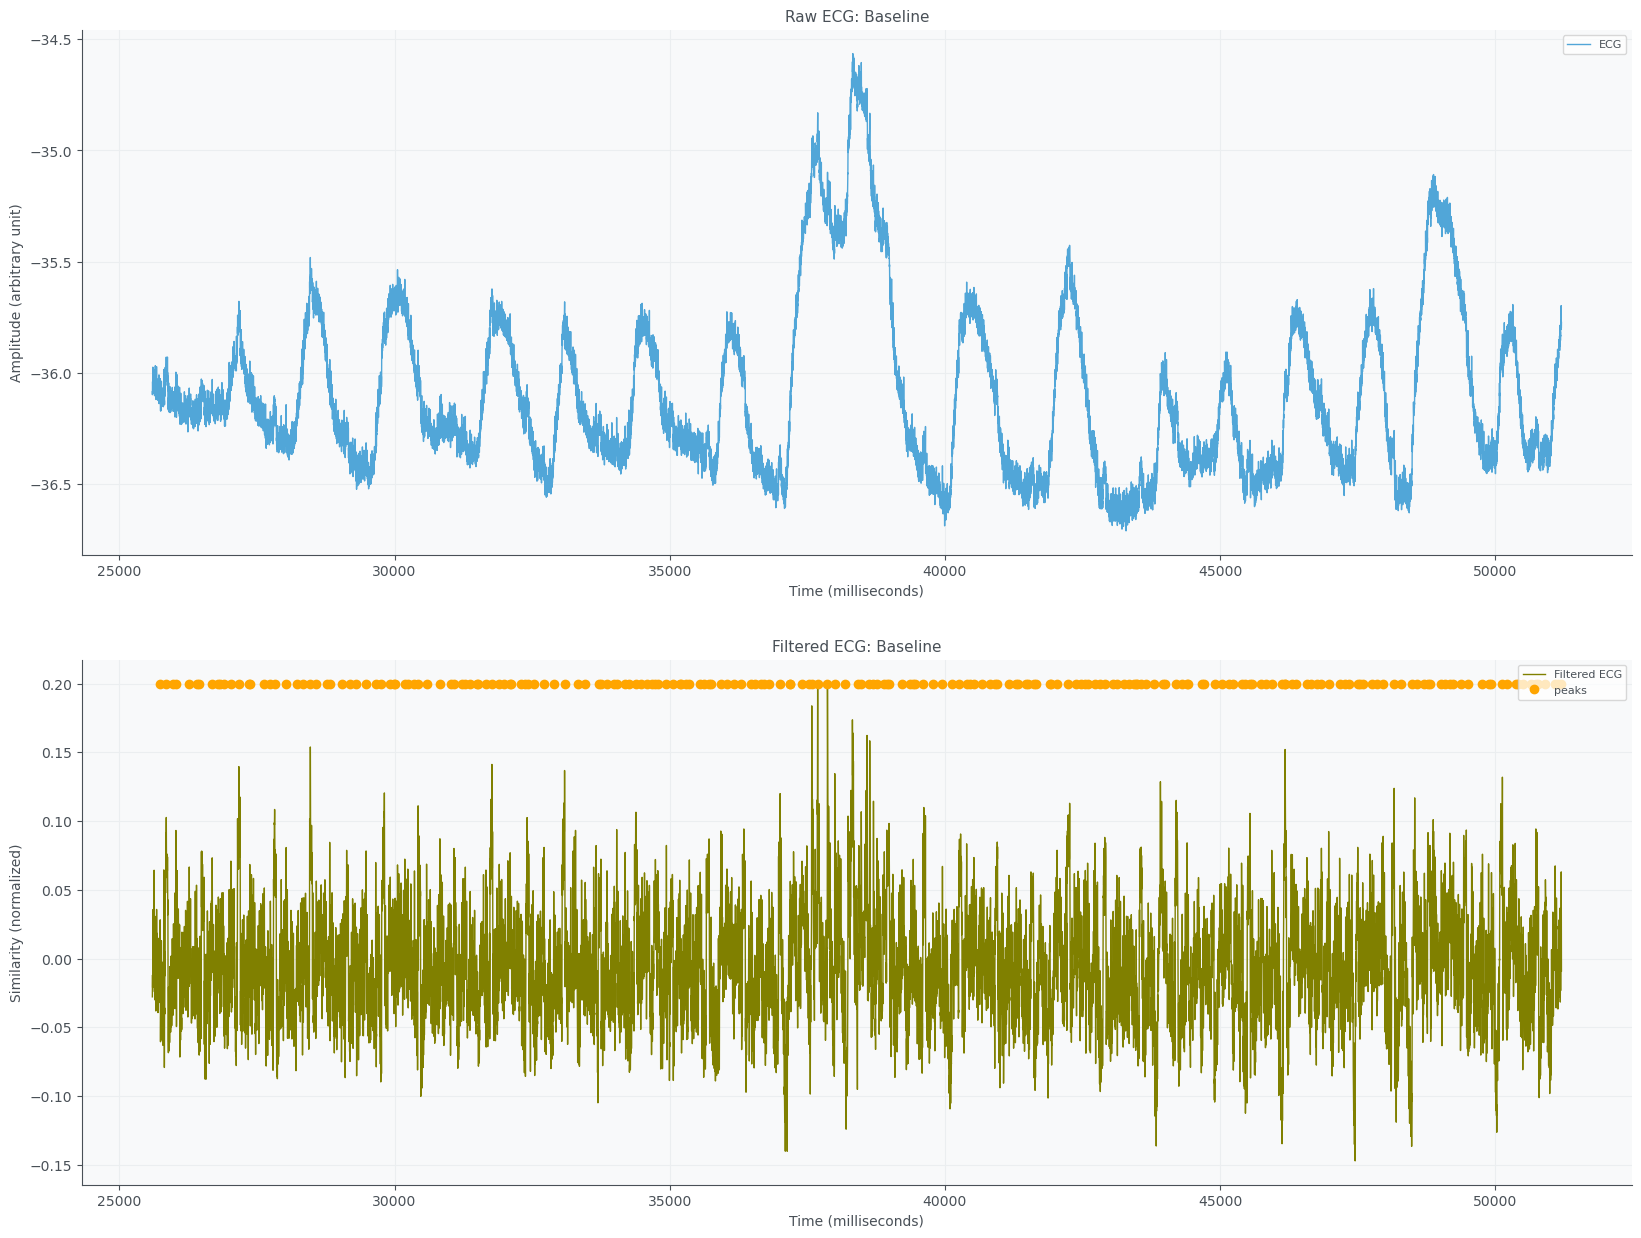

0_25600_Baseline0.svg
51200
76800


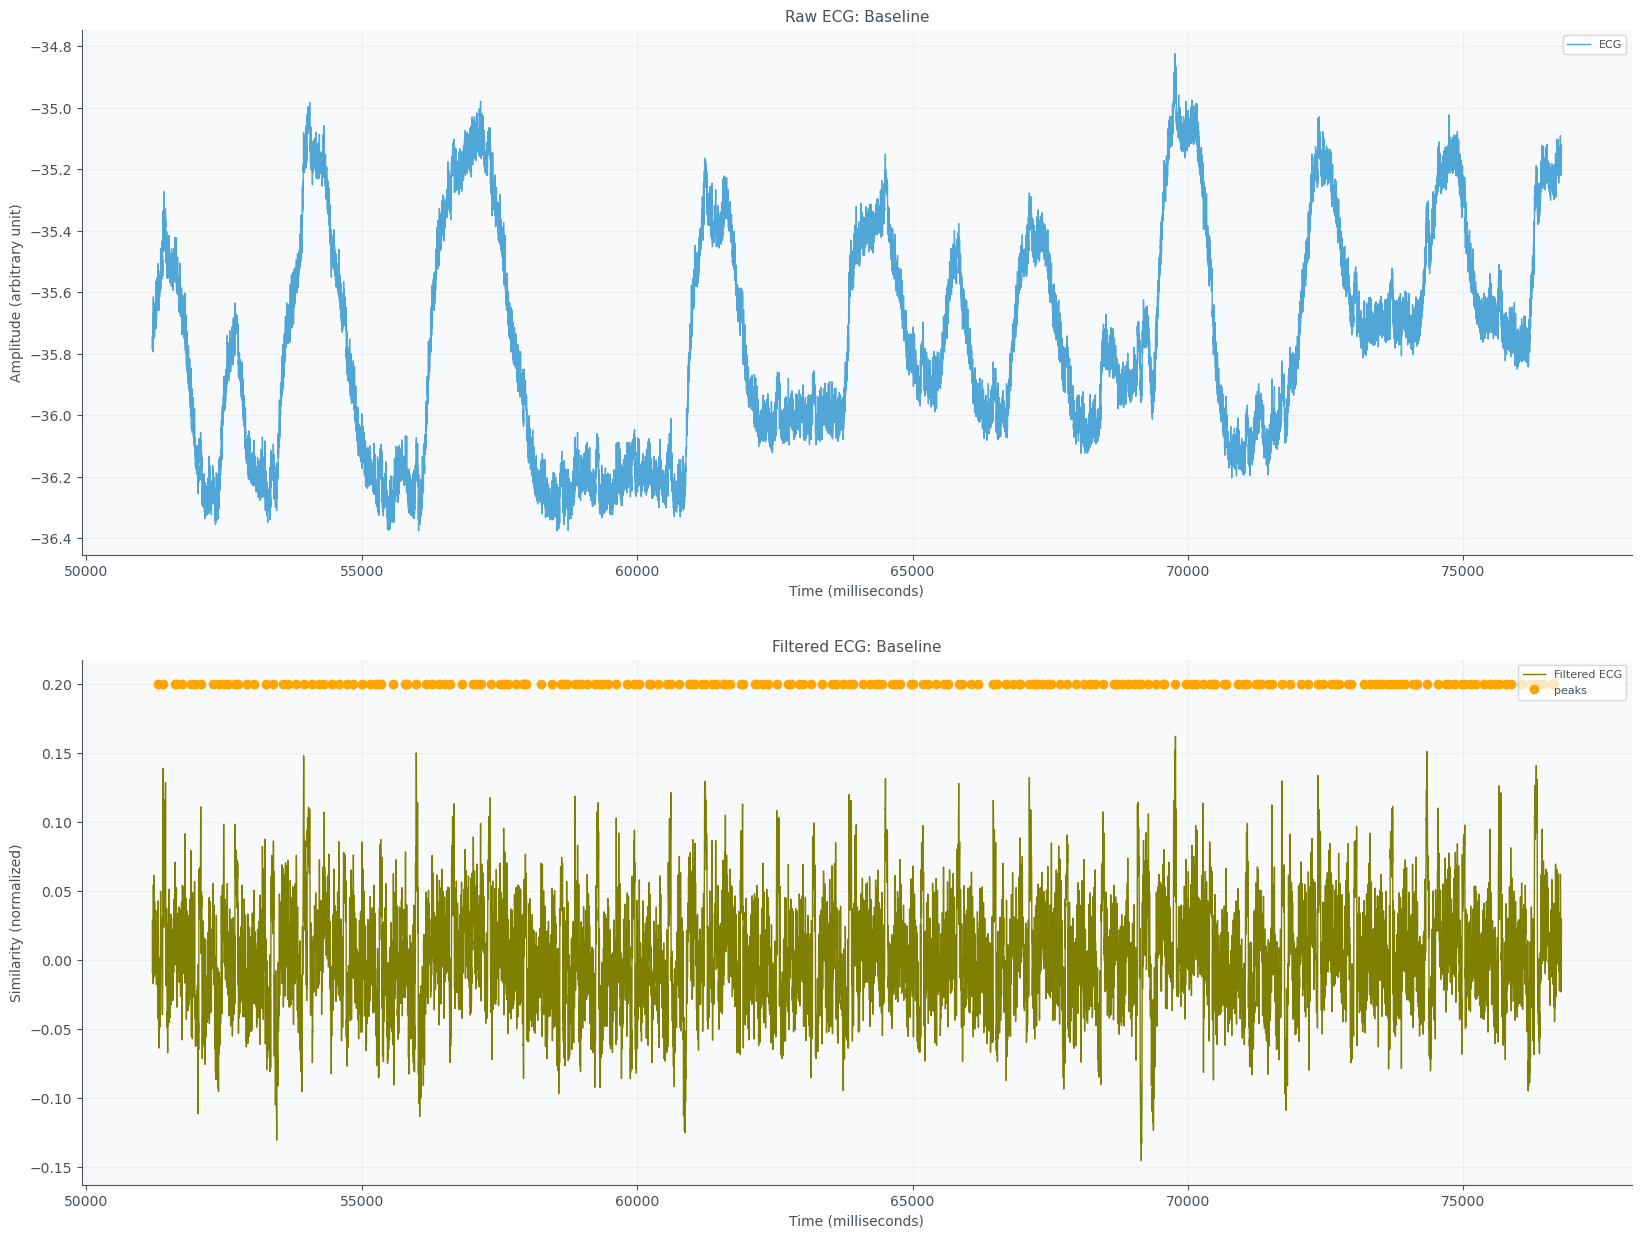

25600_51200_0_25600_Baseline0.svg
baseline start time: 2023-09-19 11:02:54.008638+02:00
baseline stop time: 2023-09-19 11:07:54.008638+02:00
shimmer_baseline start time: 2023-09-19 11:02:54.011627+02:00
shimmer_baseline stop time: 2023-09-19 11:07:54.007721+02:00
TASK DATA
0
25600


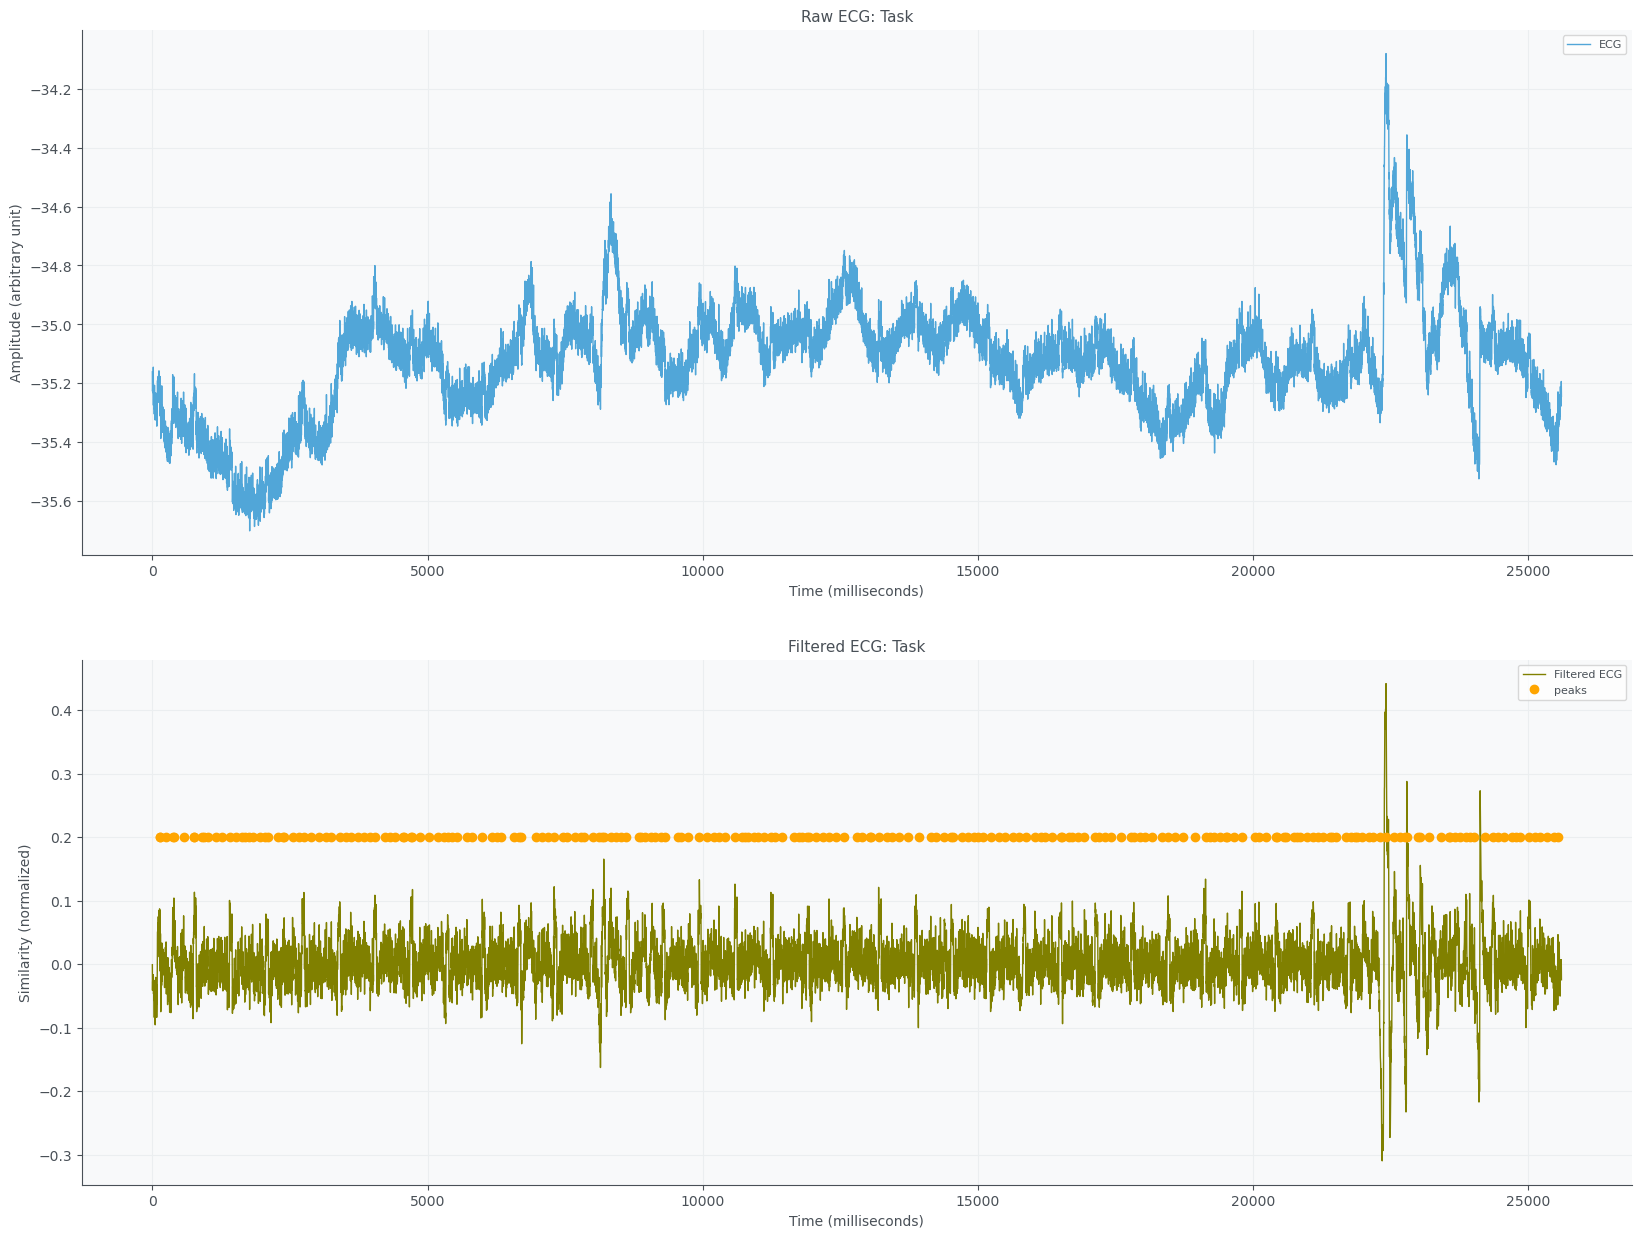

Task0.png
25600
51200


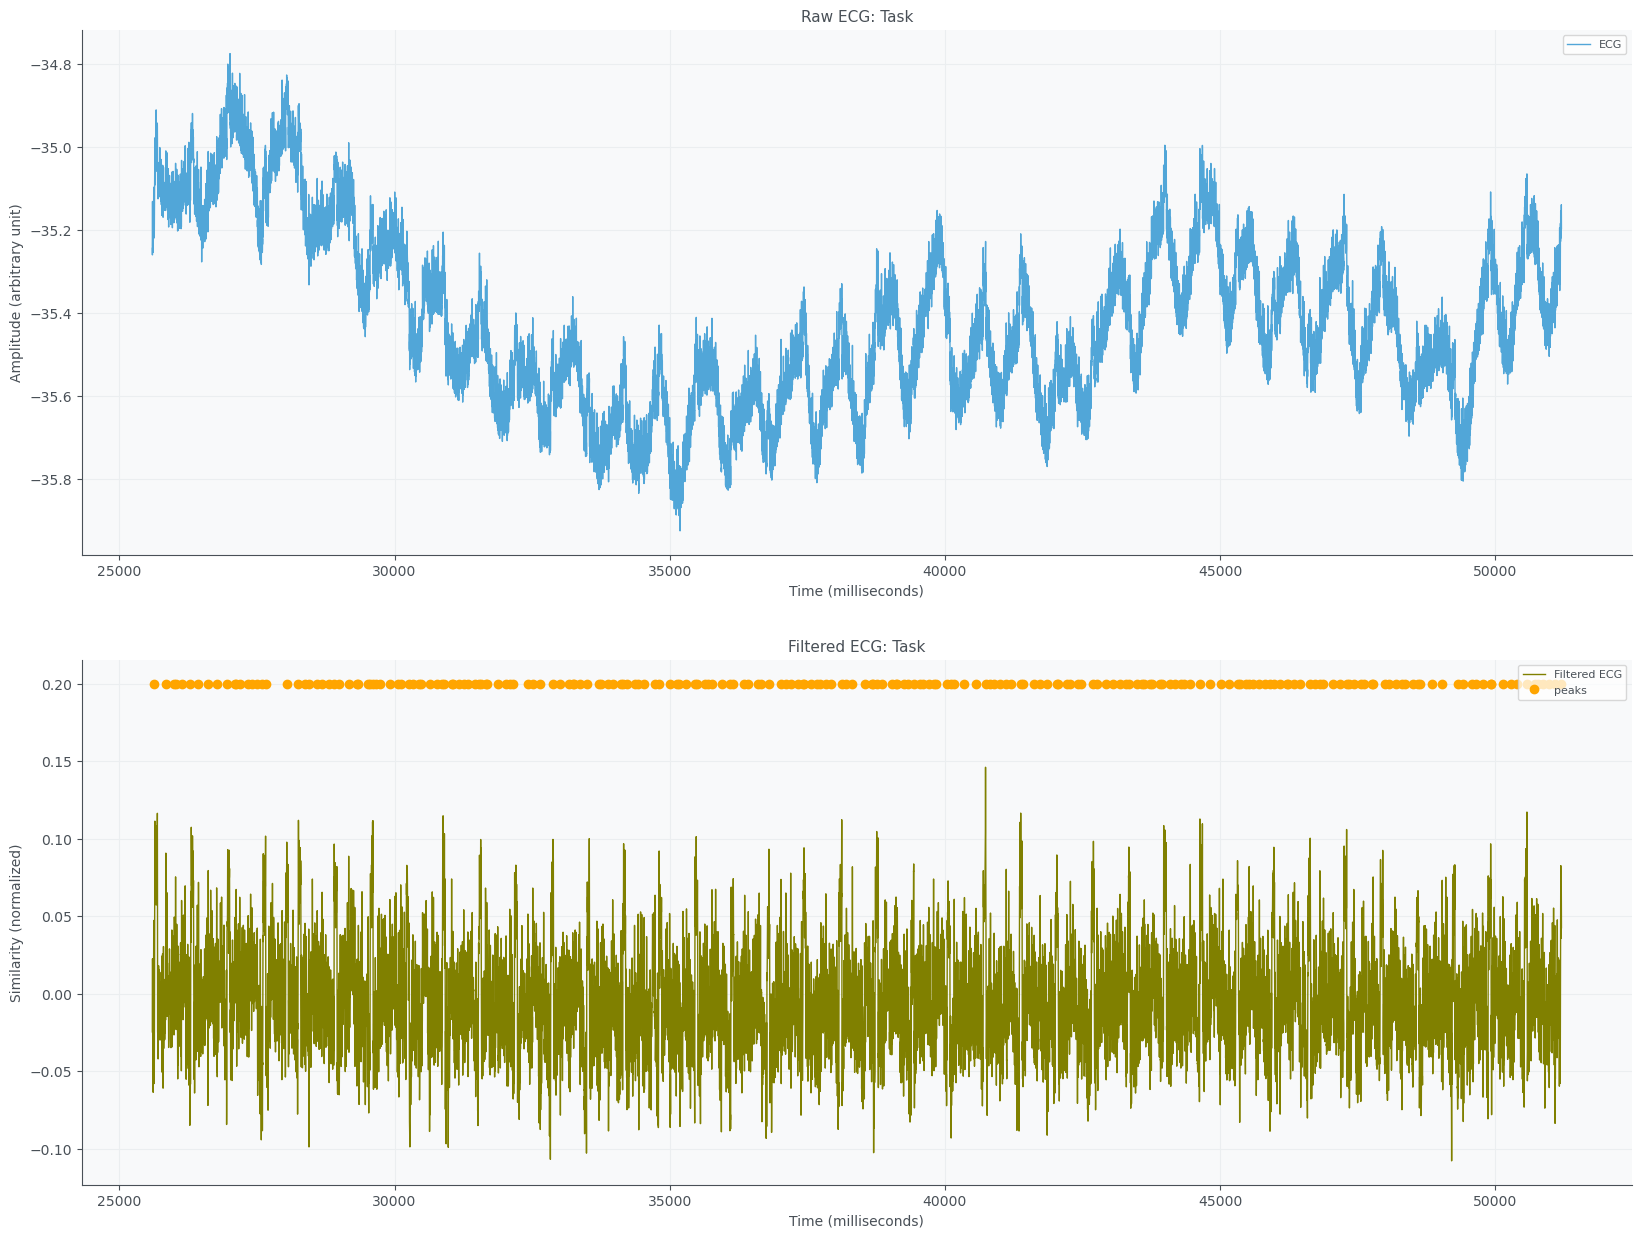

0_25600_Task0.png
51200
76800


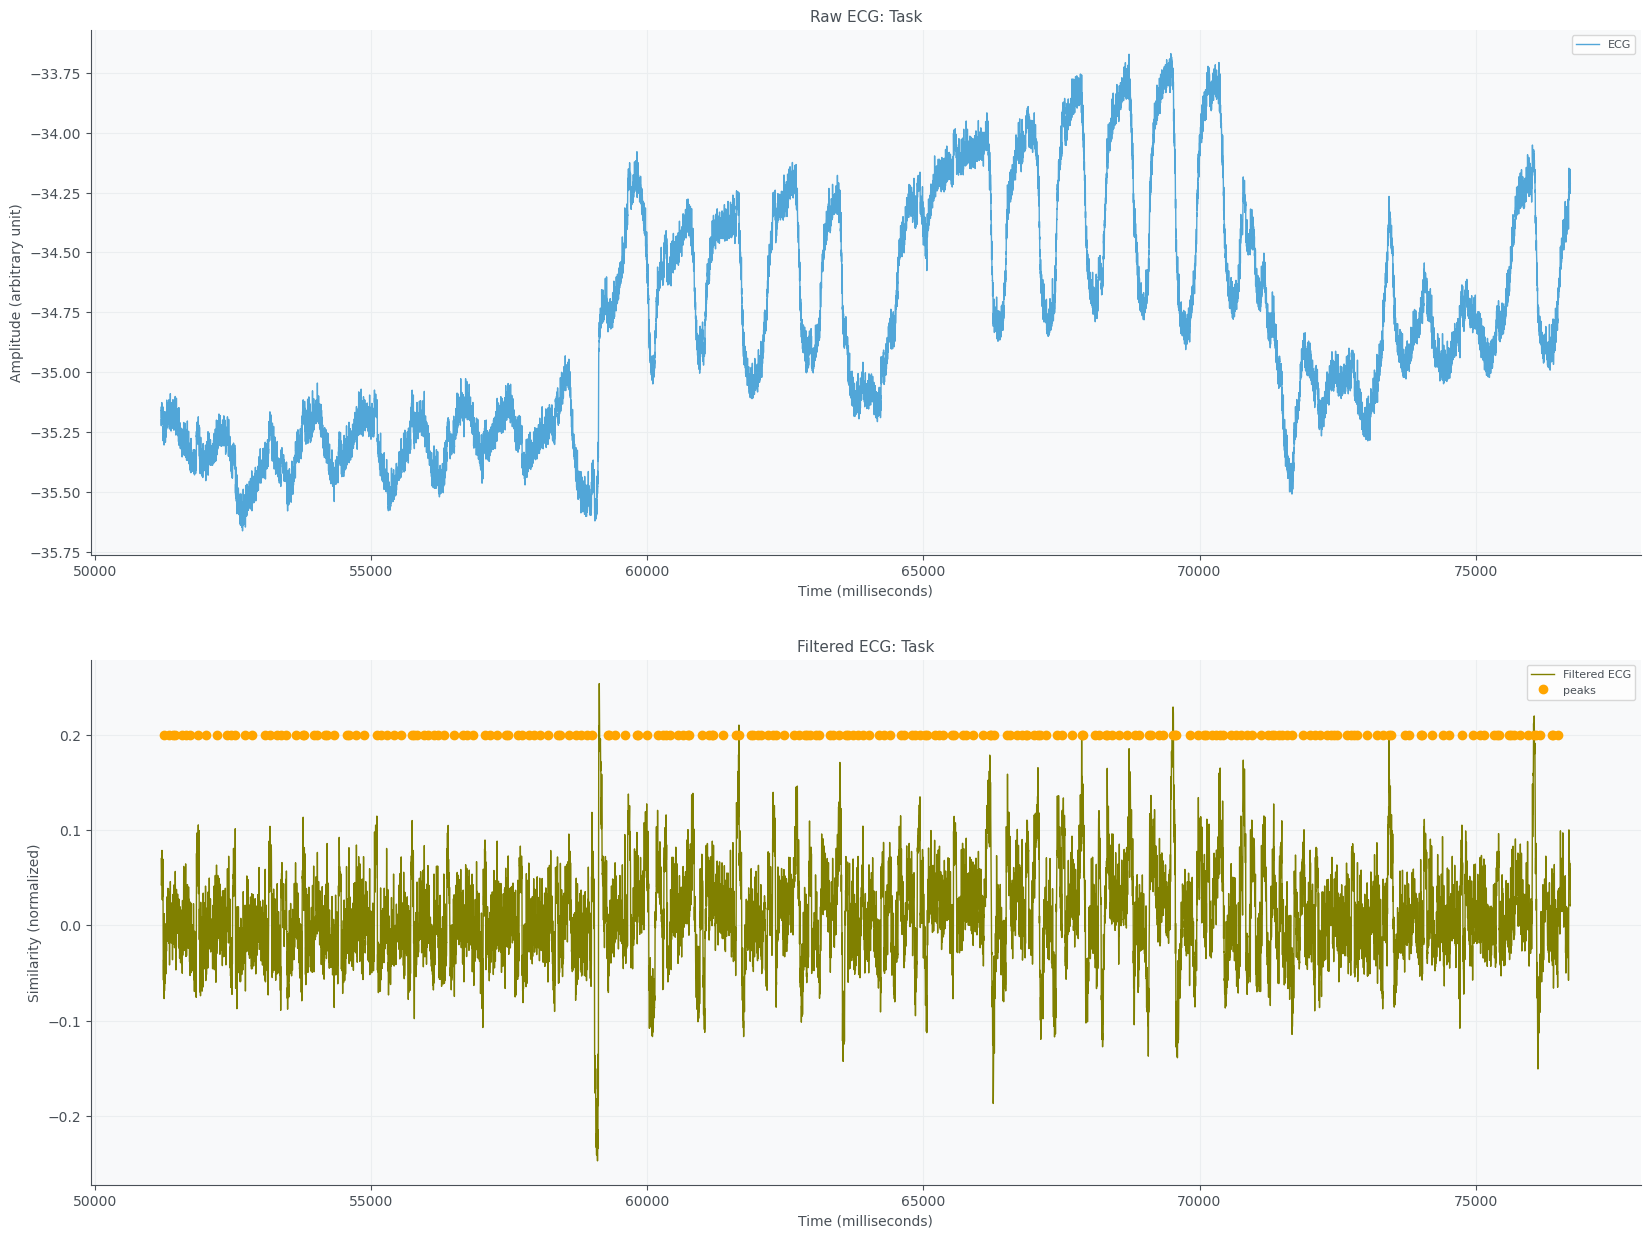

25600_51200_0_25600_Task0.png
task start time: 2023-09-19 11:07:54.295927+02:00
task stop time: 2023-09-19 11:12:54.295927+02:00
shimmer_task start time: 2023-09-19 11:07:54.296783+02:00
shimmer_task stop time: 2023-09-19 11:12:54.292877+02:00
recovery start time: 2023-09-19 11:12:55.301124+02:00
recovery stop time: 2023-09-19 11:17:55.301124+02:00
shimmer_recovery start time: 2023-09-19 11:12:55.304596+02:00
shimmer_recovery stop time: 2023-09-19 11:17:55.300690+02:00
psychopy_events_triggers_WP2_03_VEOQ_pre_assesment.pkl


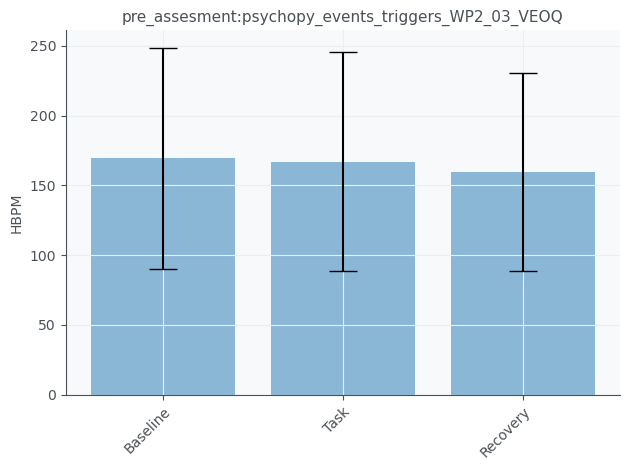

RECOVERY DATA
0
25600


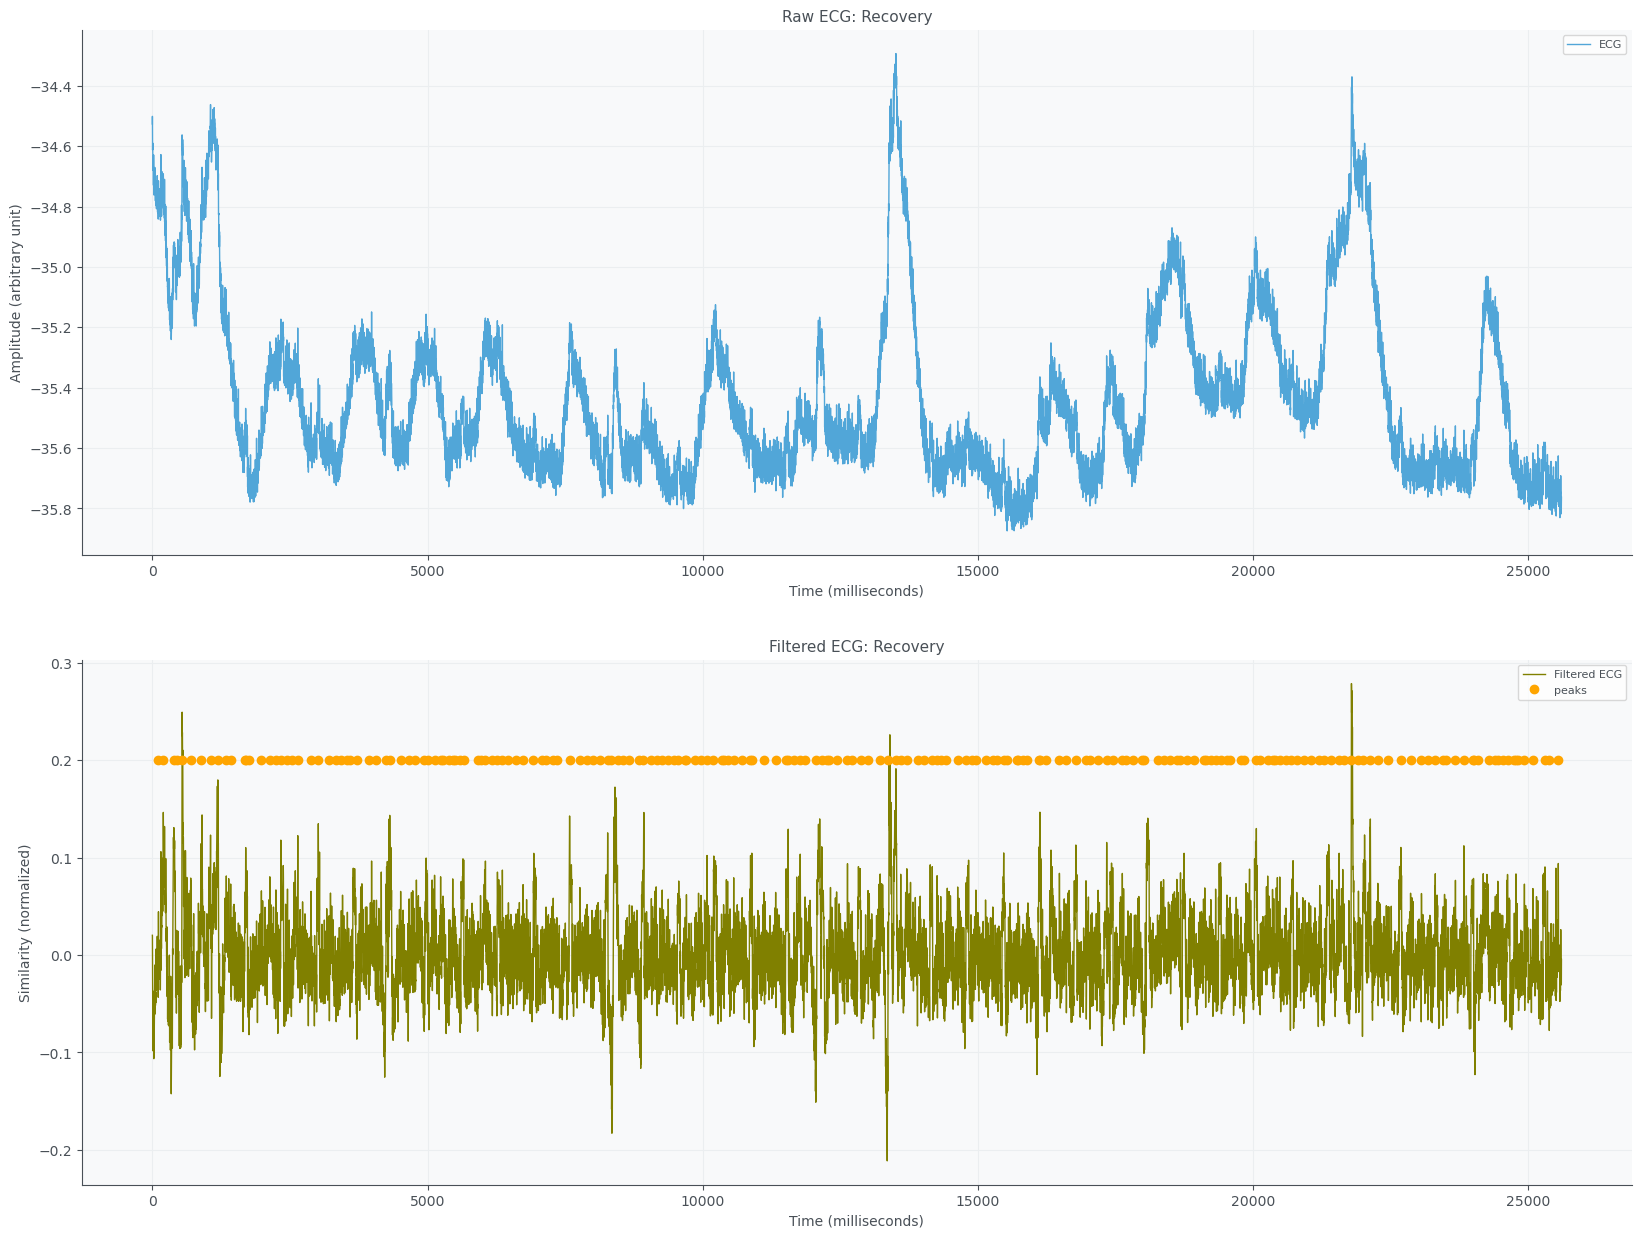

Recovery0.png
25600
51200


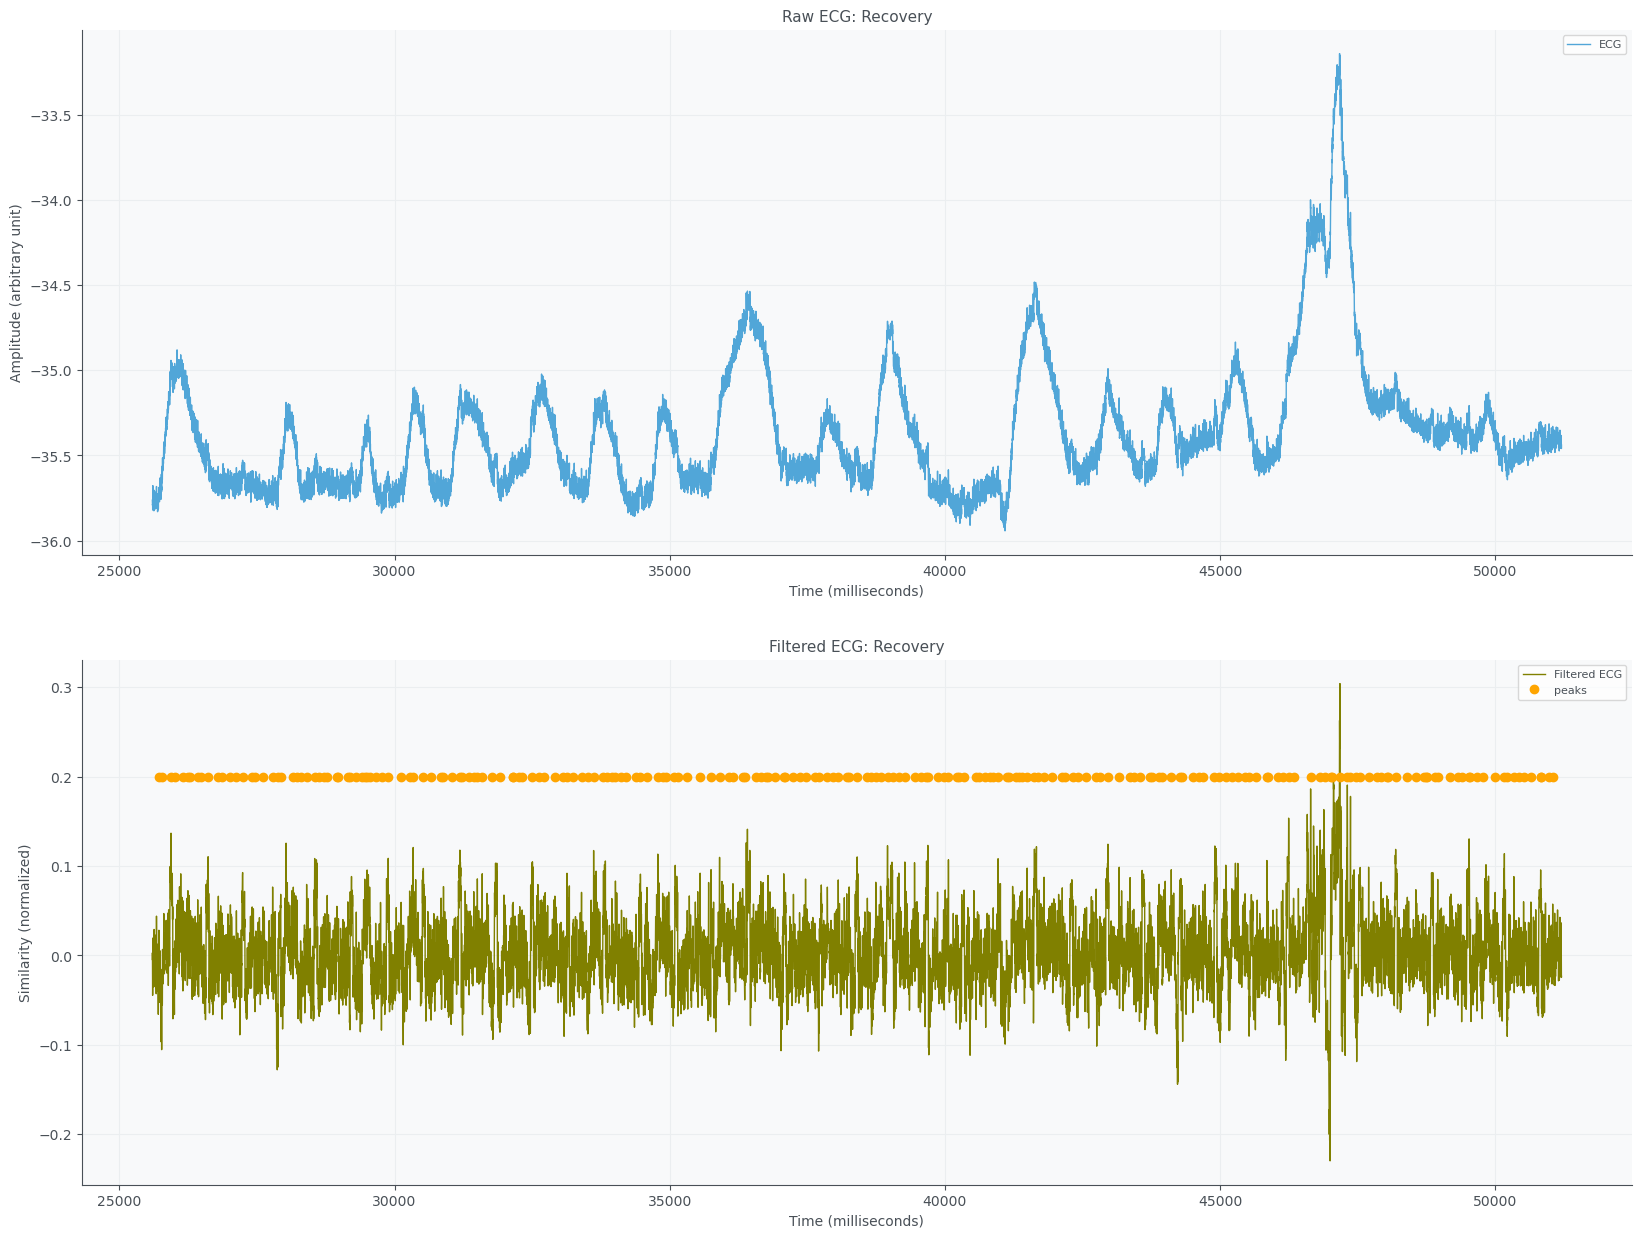

0_25600_Recovery0.png
51200
76800


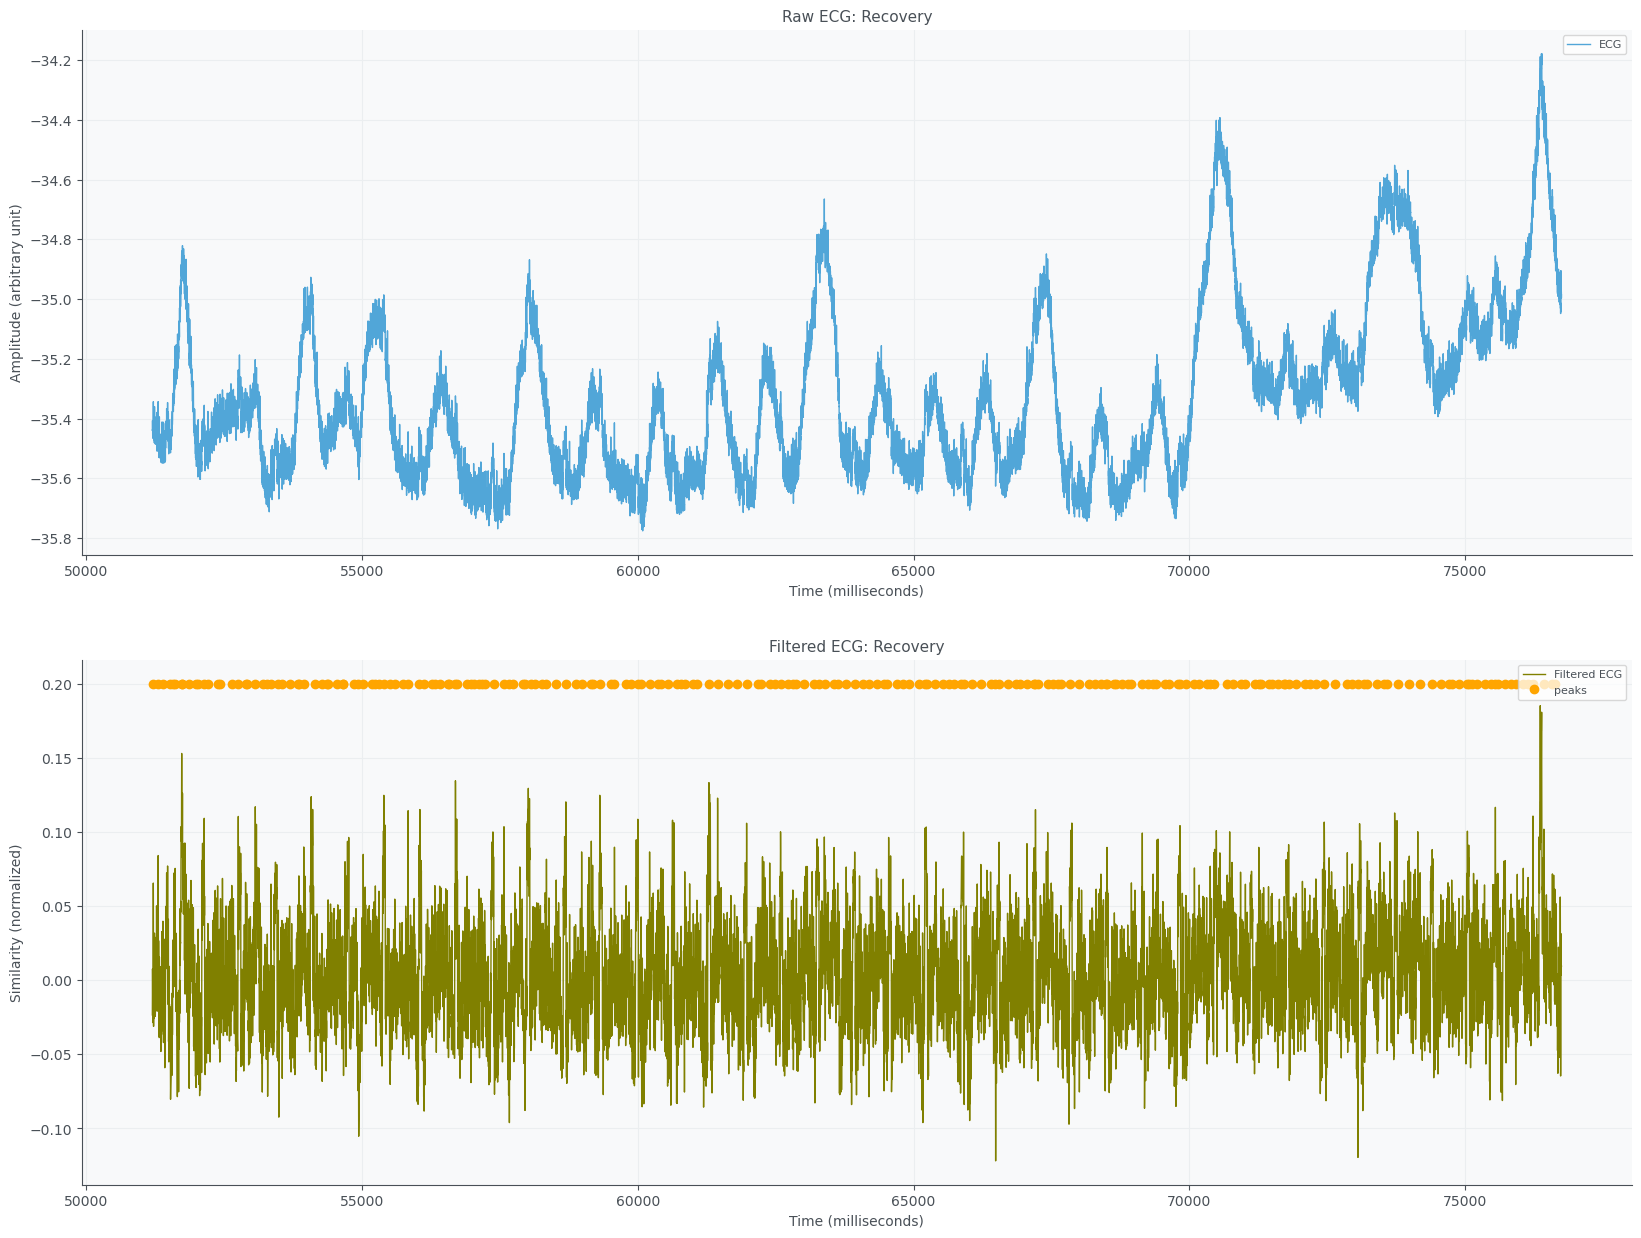

25600_51200_0_25600_Recovery0.png
positive
BASELINE DATA
0
25600


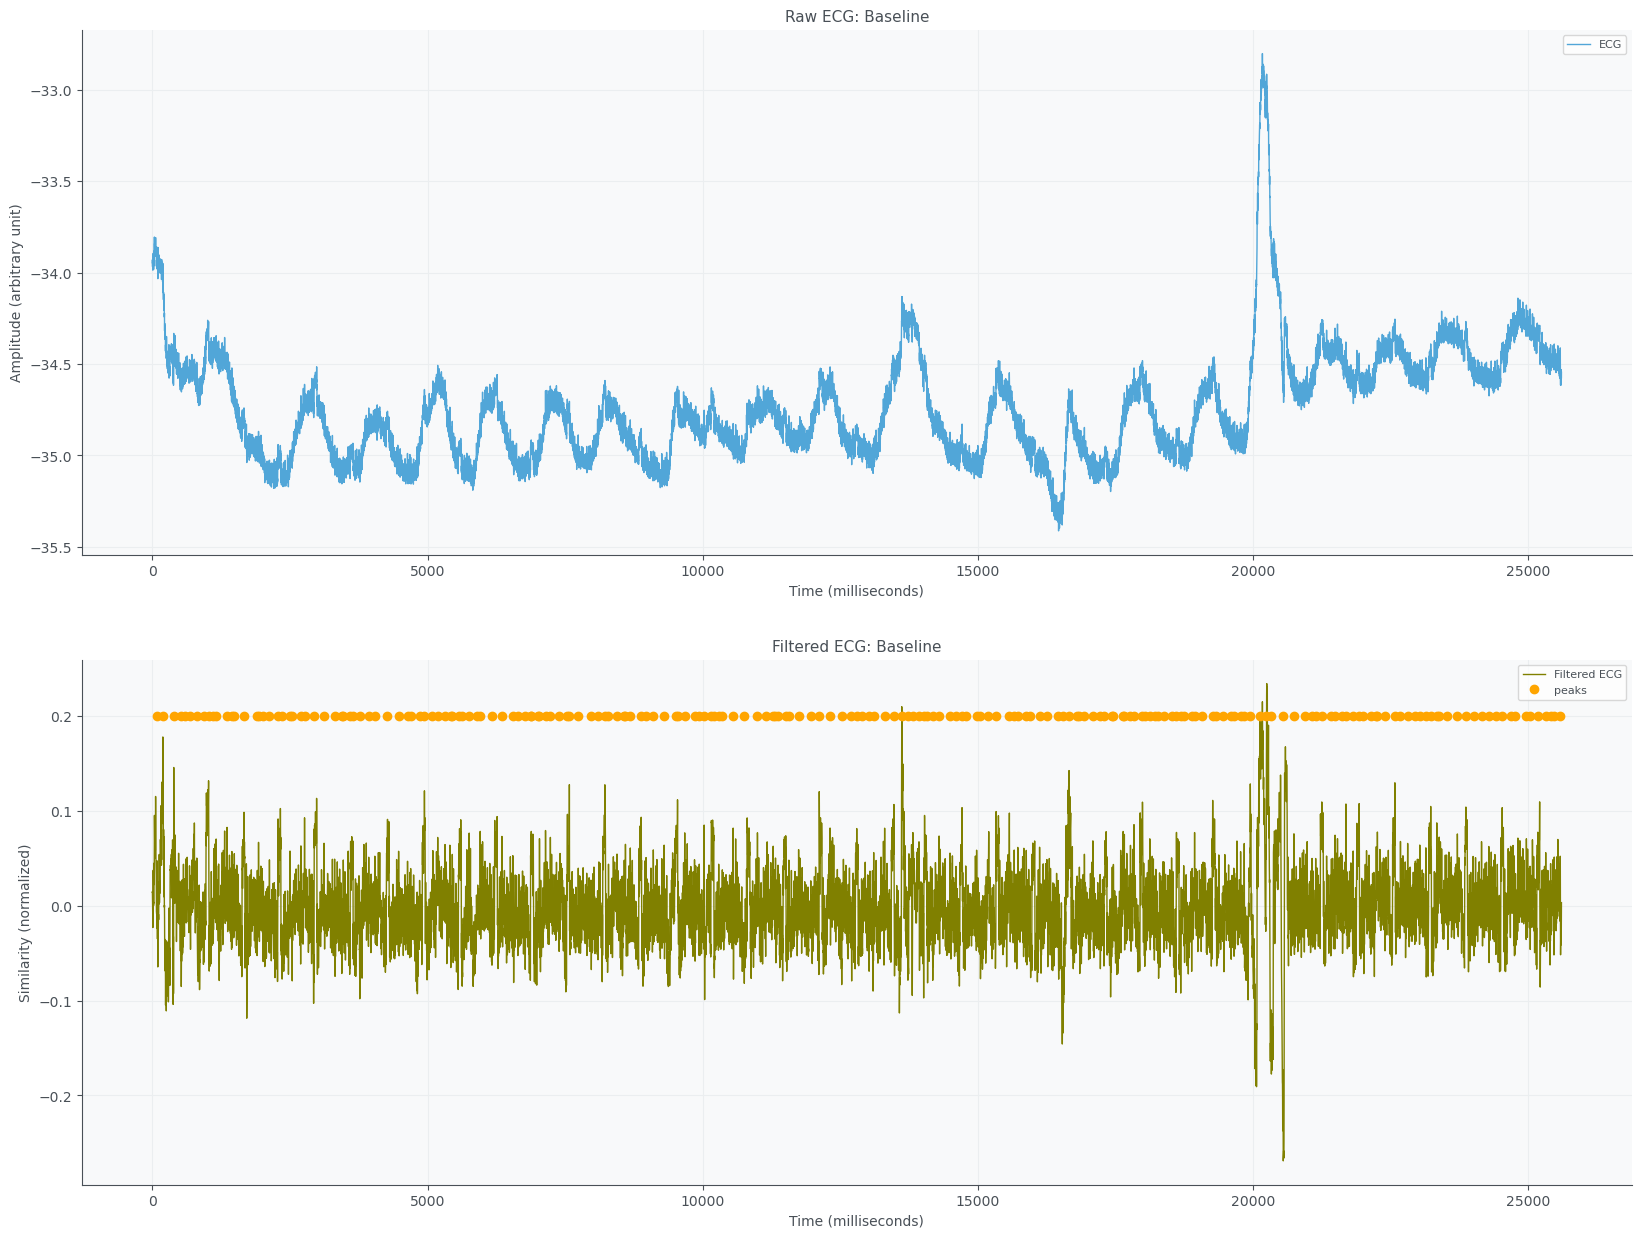

Baseline1.svg
25600
51200


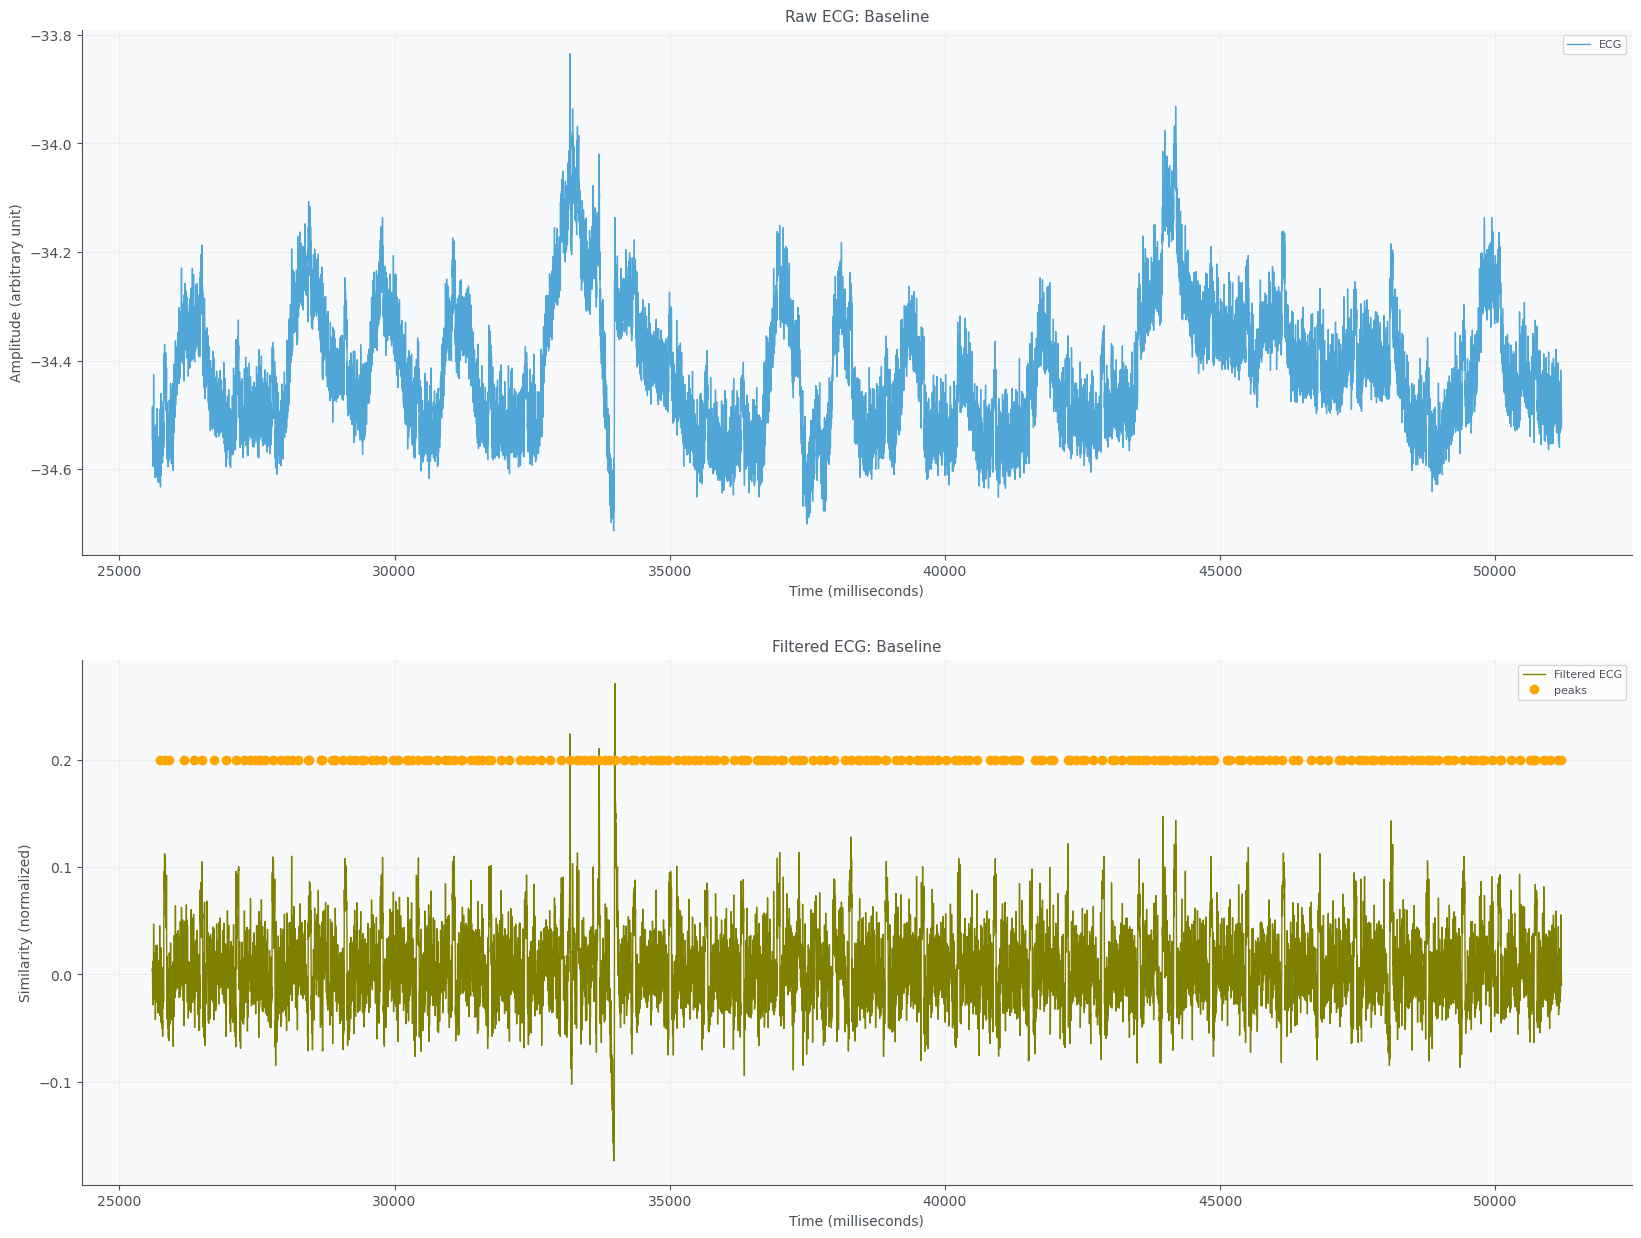

0_25600_Baseline1.svg
51200
76800


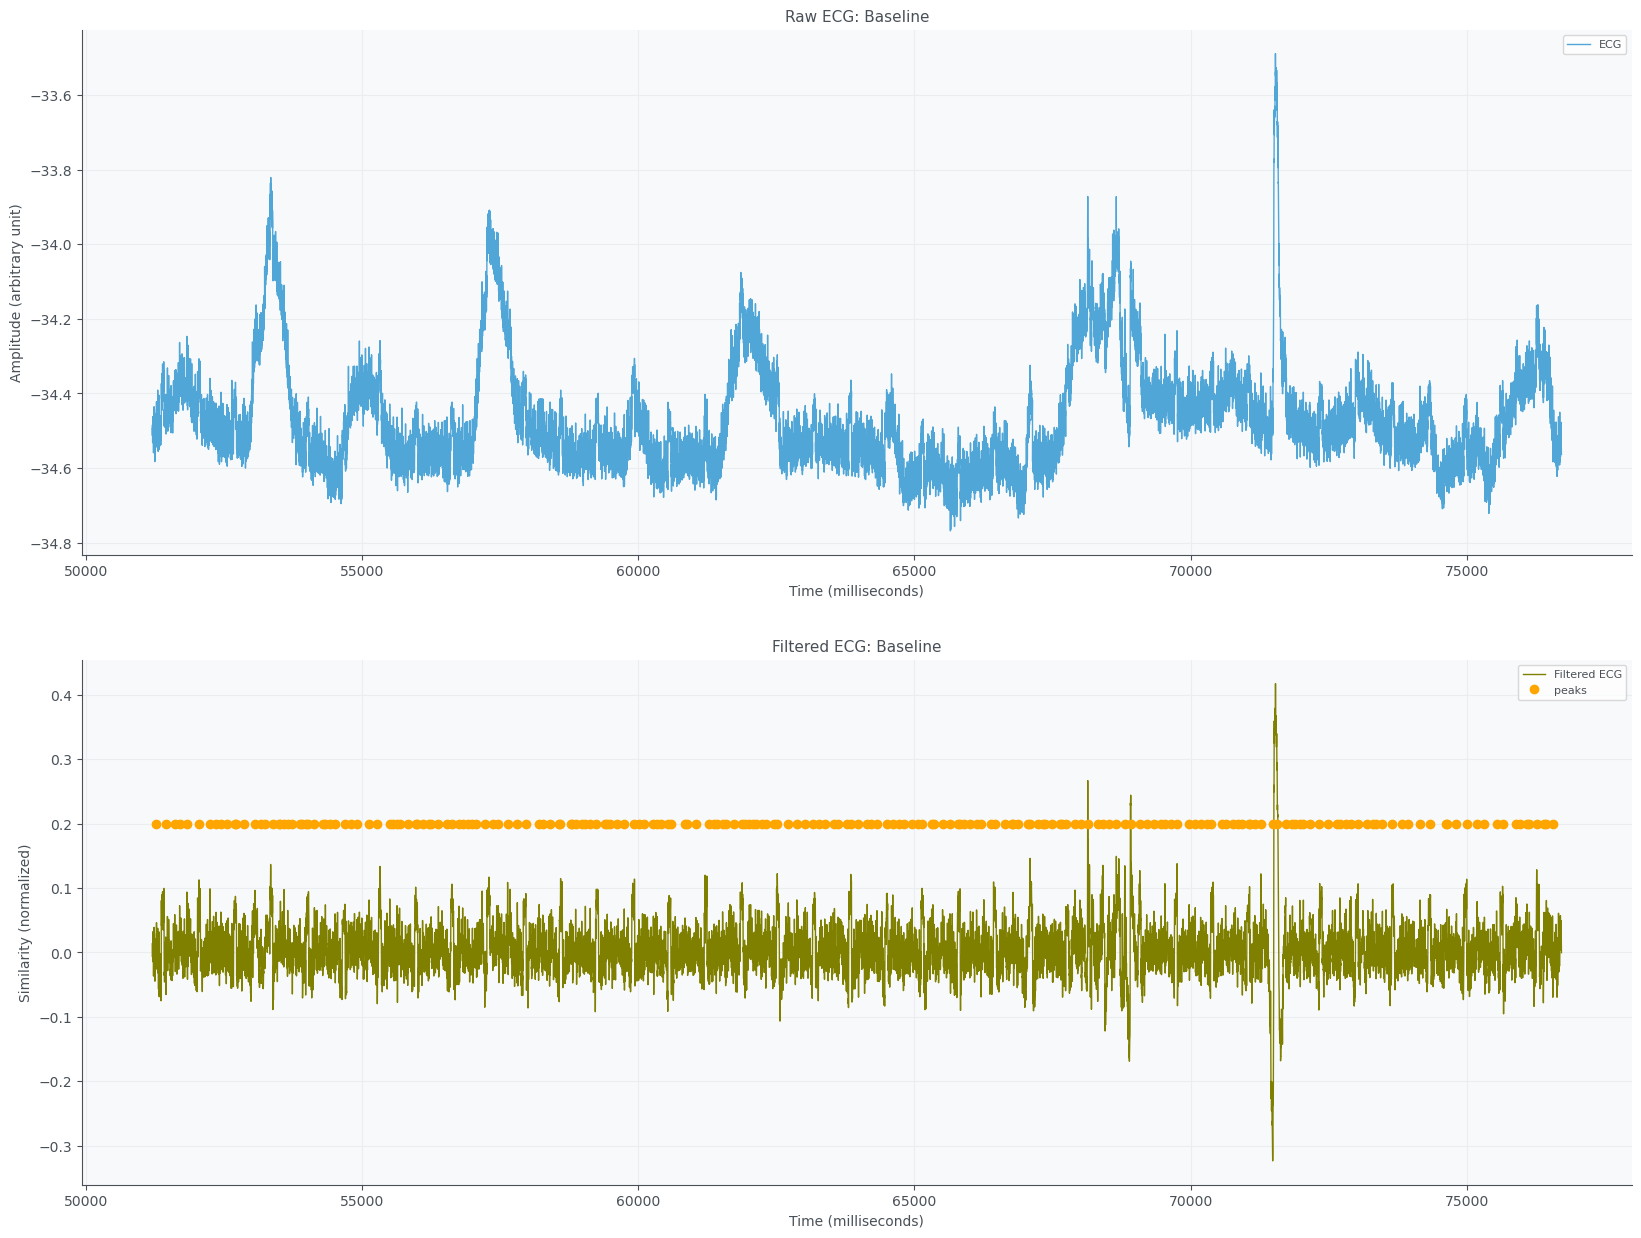

25600_51200_0_25600_Baseline1.svg
baseline start time: 2023-09-19 11:19:27.172204+02:00
baseline stop time: 2023-09-19 11:24:27.172204+02:00
shimmer_baseline start time: 2023-09-19 11:19:27.175690+02:00
shimmer_baseline stop time: 2023-09-19 11:24:27.171783+02:00
TASK DATA
0
25600


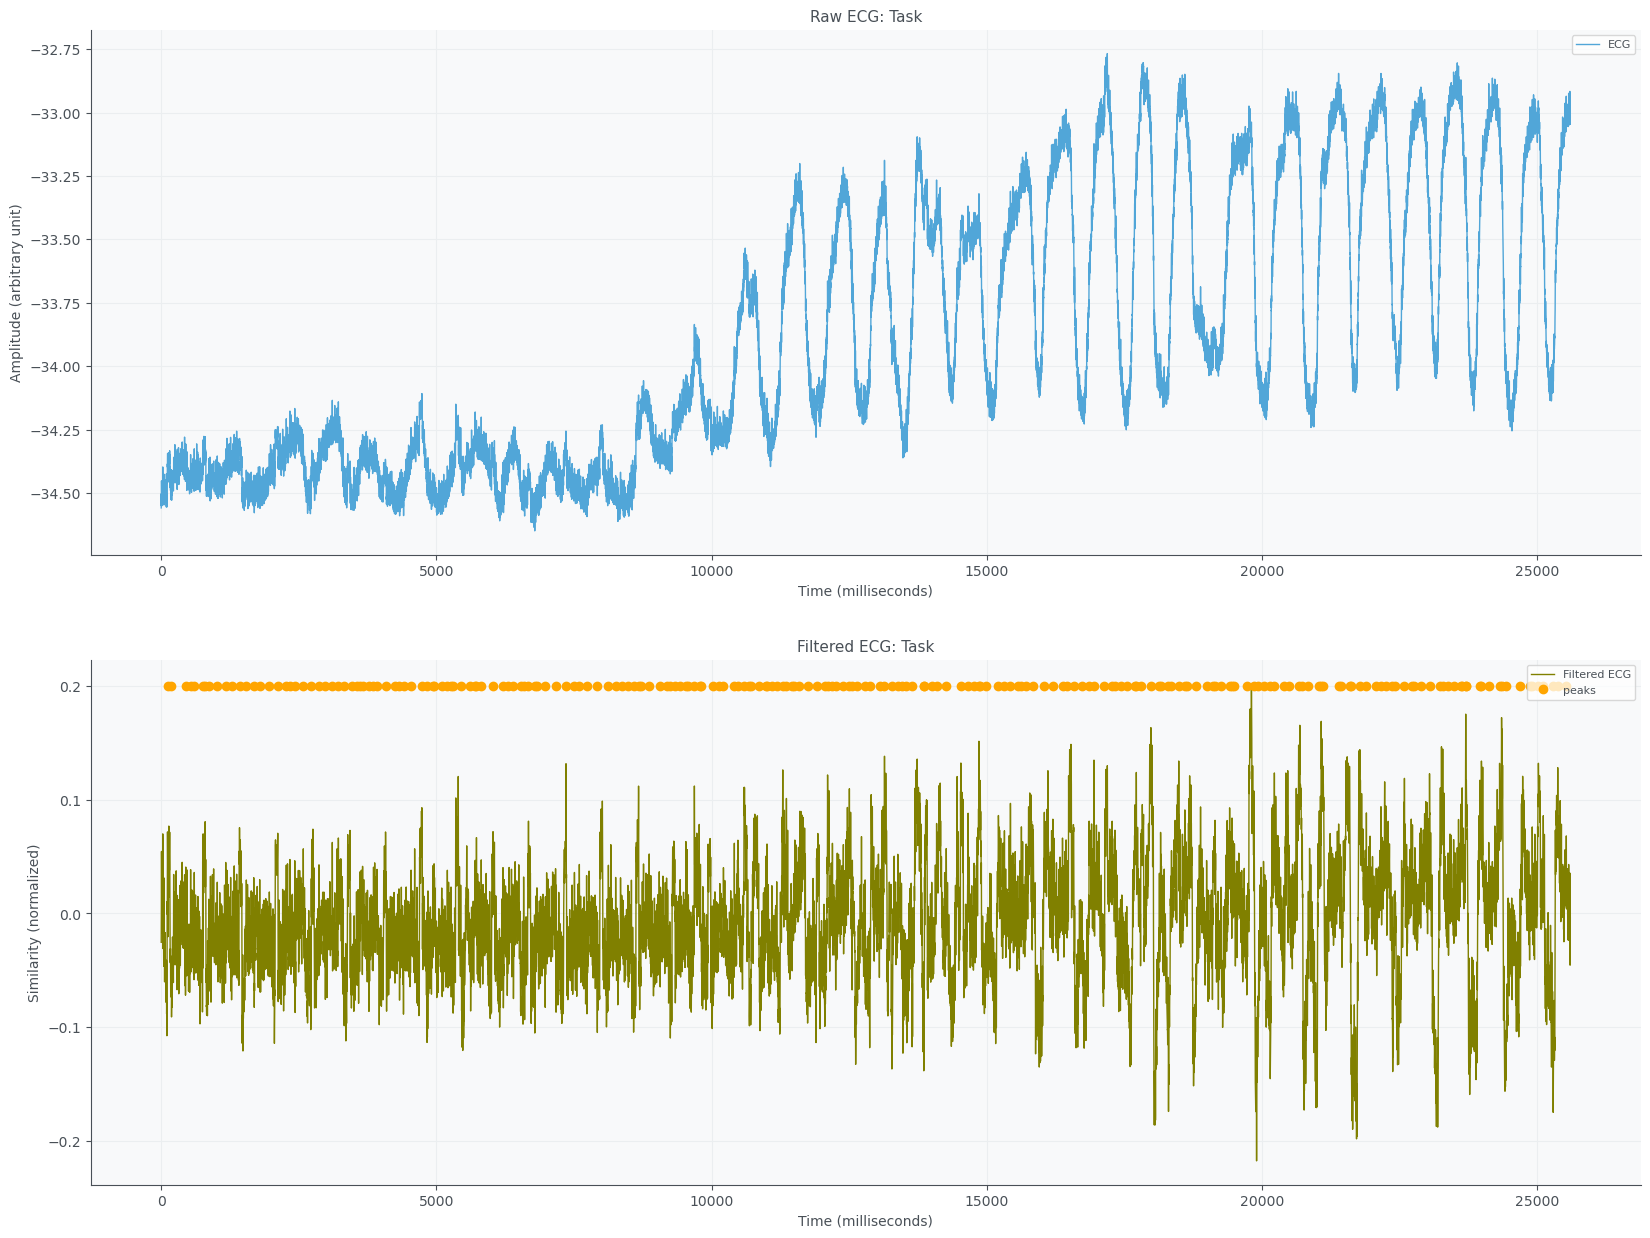

Task1.png
25600
51200


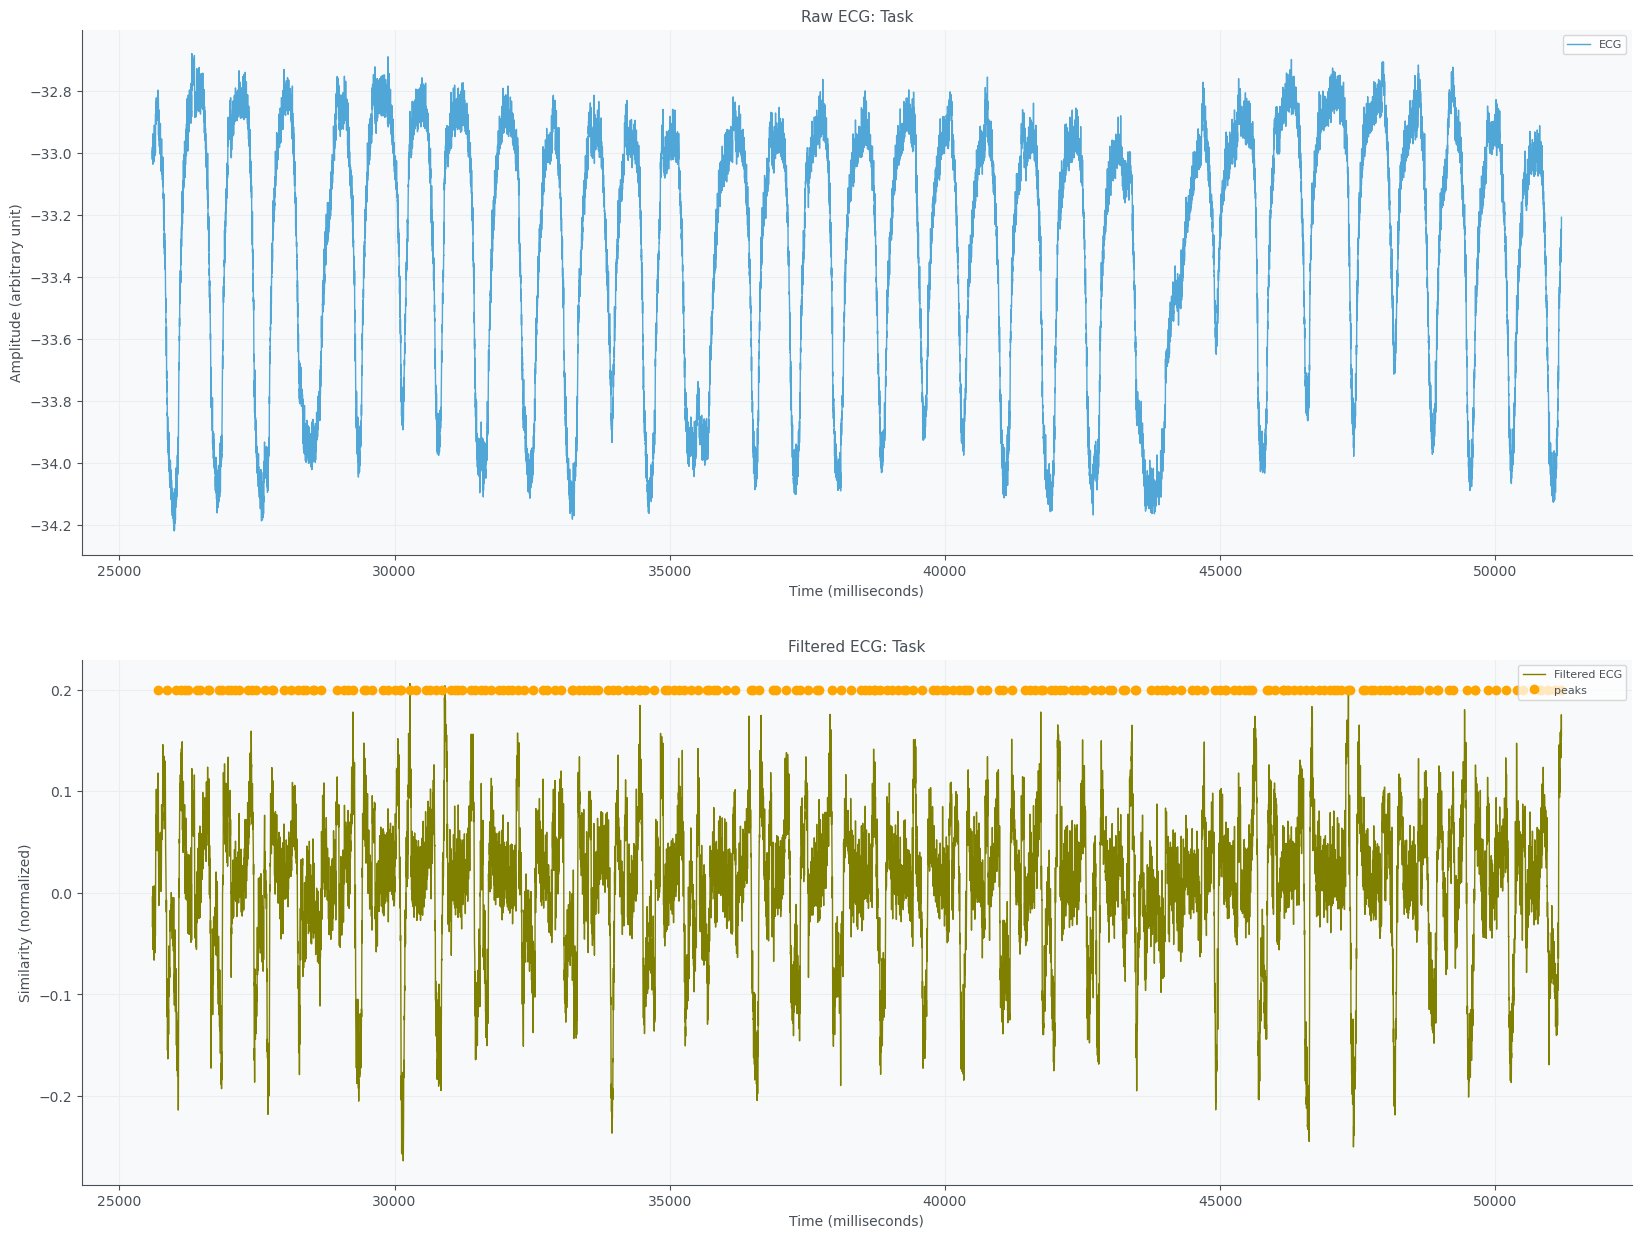

0_25600_Task1.png
51200
76800


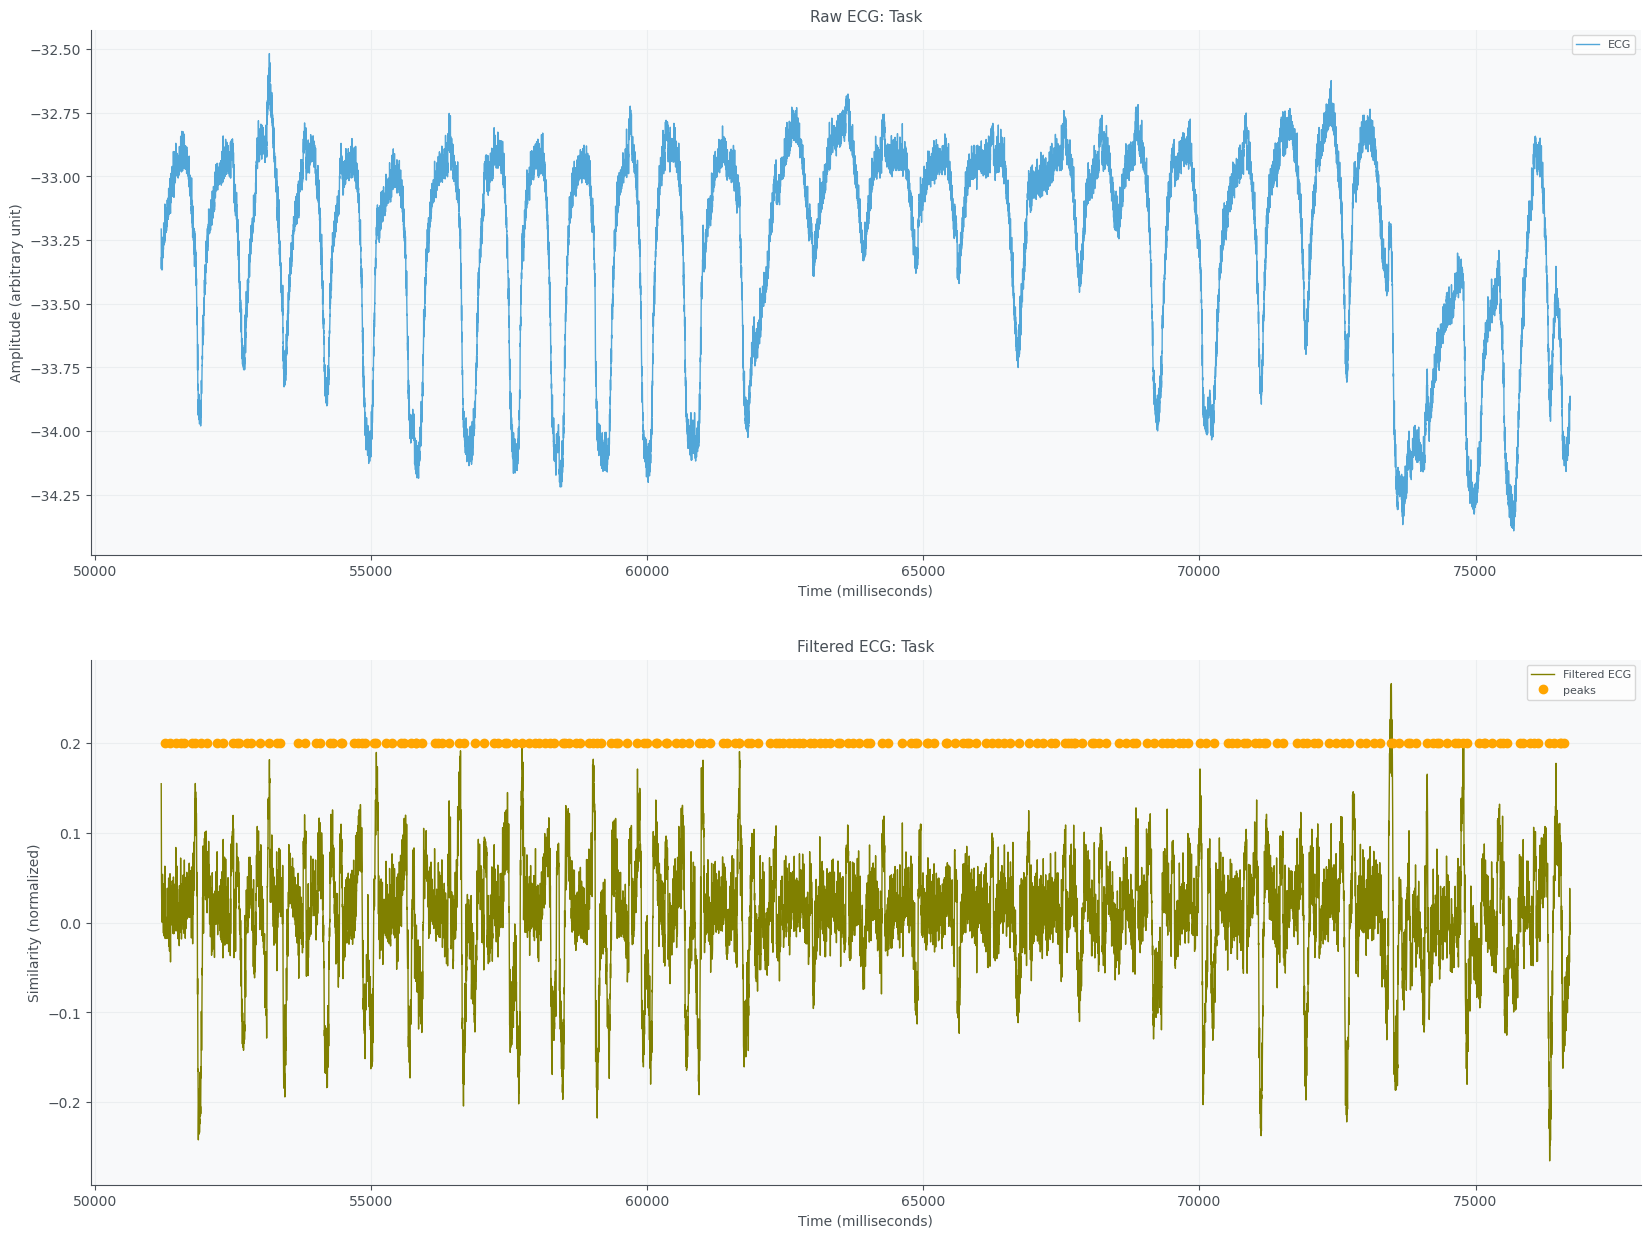

25600_51200_0_25600_Task1.png
task start time: 2023-09-19 11:24:27.540362+02:00
task stop time: 2023-09-19 11:29:27.540362+02:00
shimmer_task start time: 2023-09-19 11:24:27.542877+02:00
shimmer_task stop time: 2023-09-19 11:29:27.538971+02:00
recovery start time: 2023-09-19 11:29:29.293068+02:00
recovery stop time: 2023-09-19 11:34:29.293068+02:00
shimmer_recovery start time: 2023-09-19 11:29:29.296783+02:00
shimmer_recovery stop time: 2023-09-19 11:34:29.292877+02:00
psychopy_events_triggers_WP2_03_VEOQ_positive.pkl


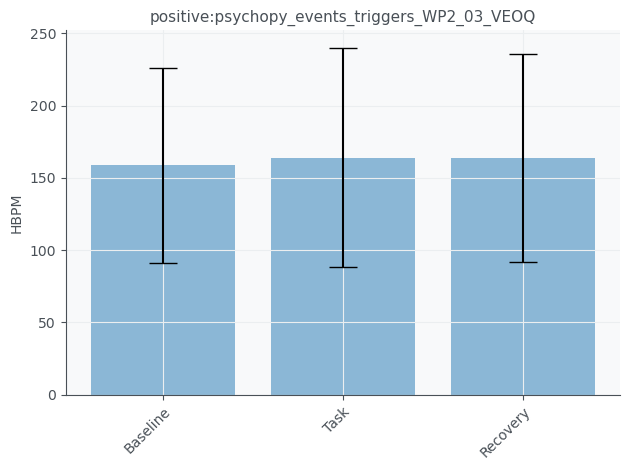

RECOVERY DATA
0
25600


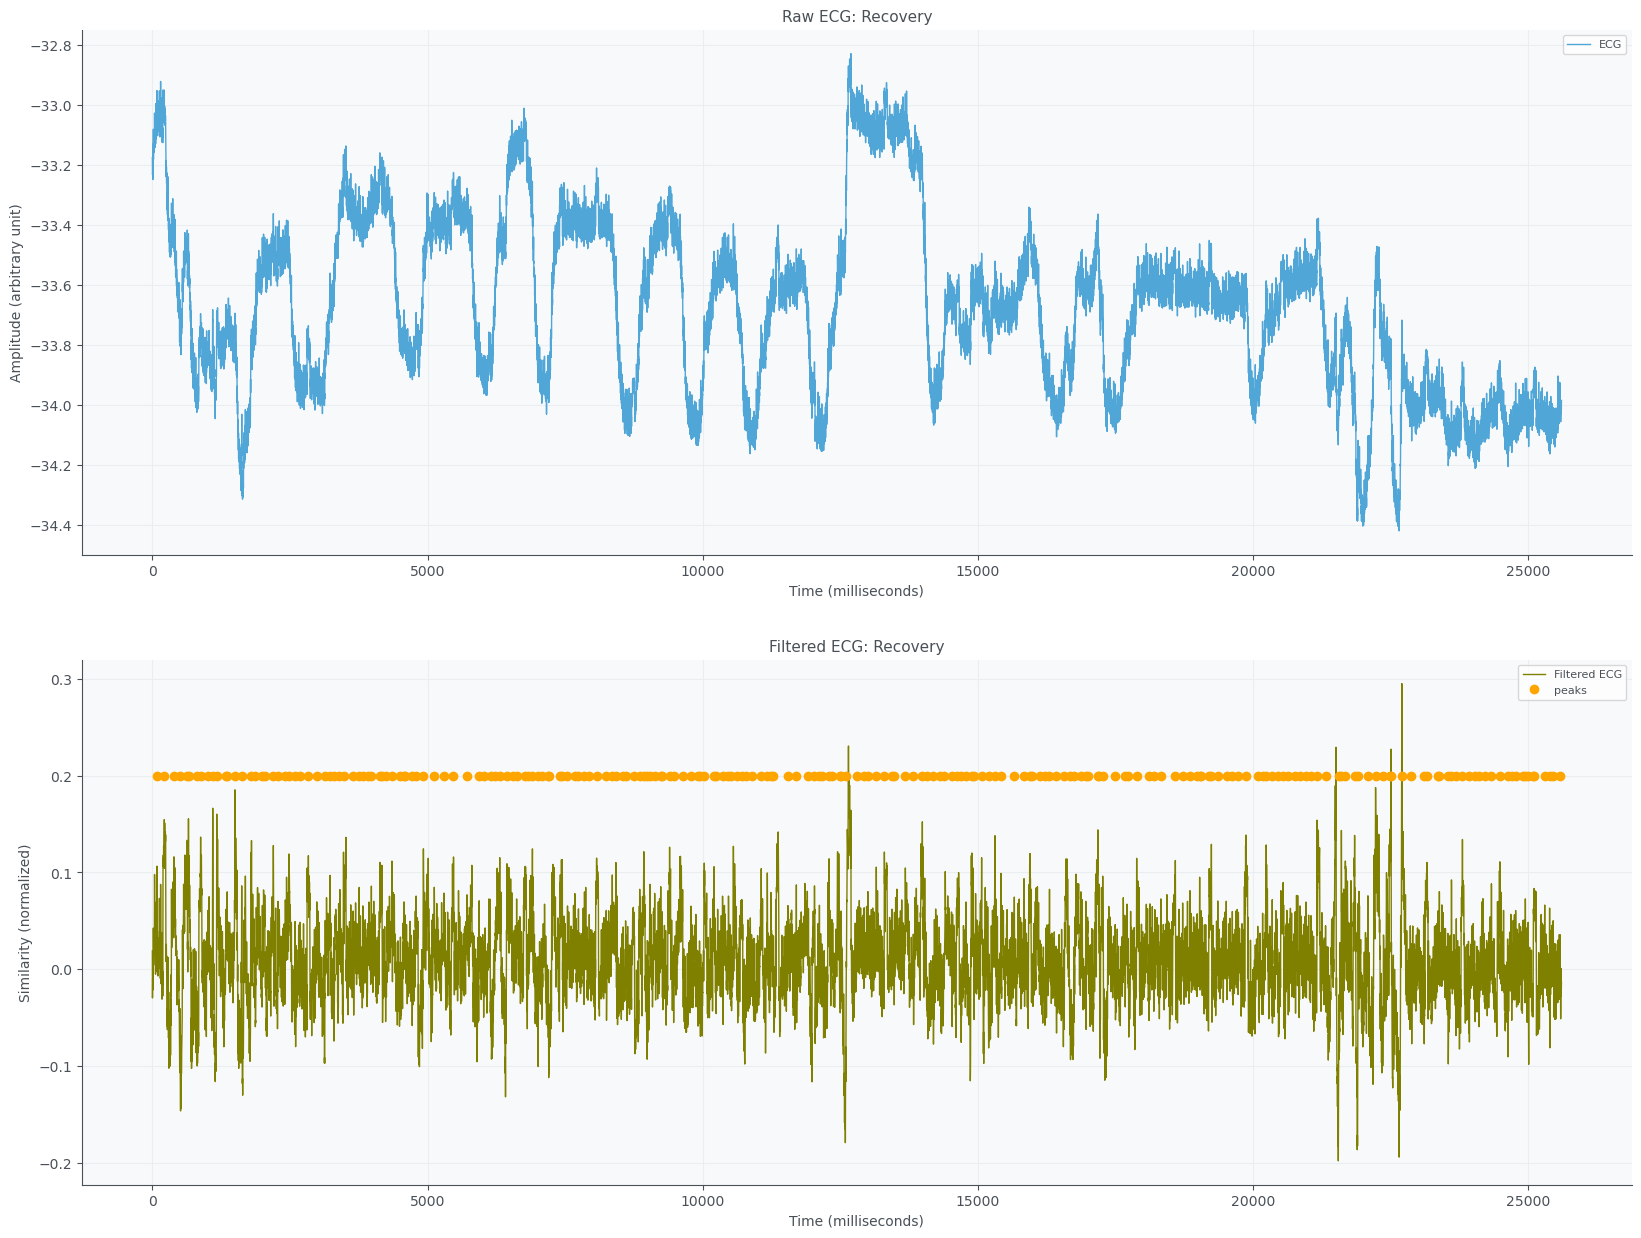

Recovery1.png
25600
51200


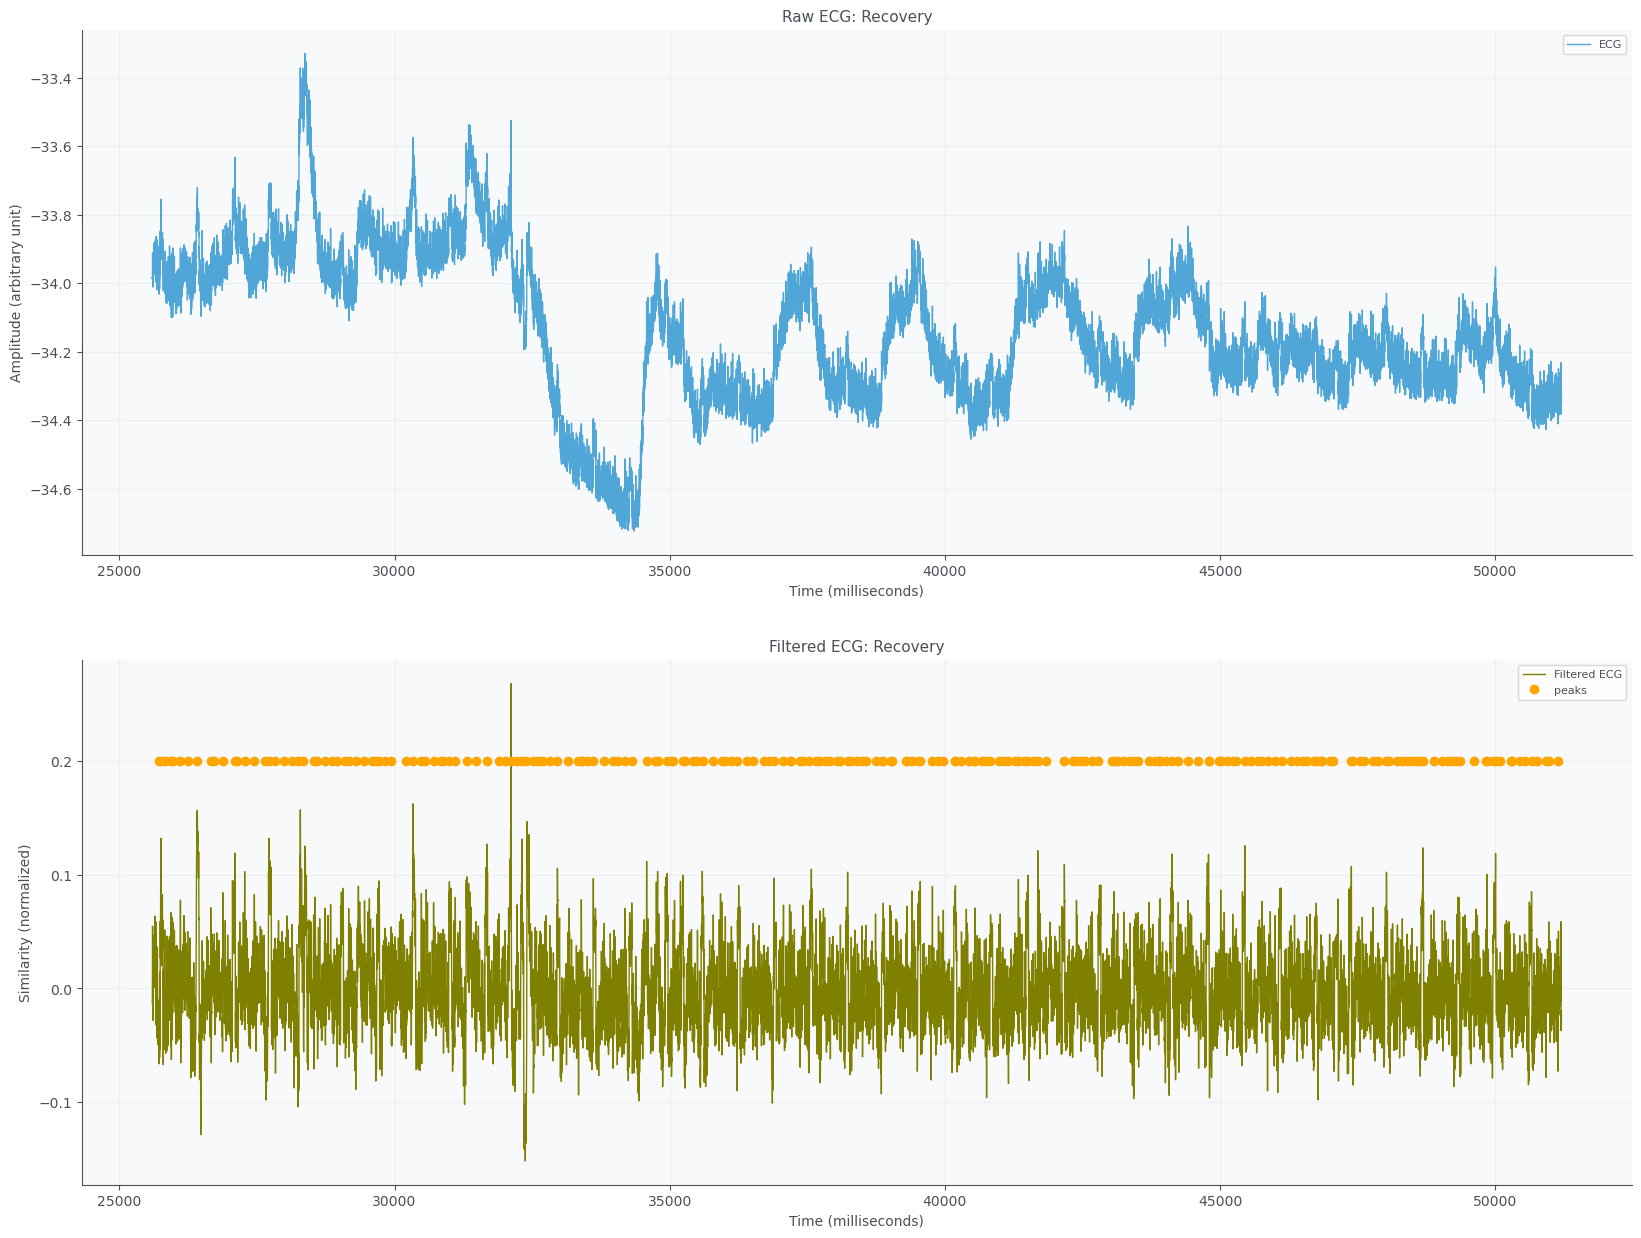

0_25600_Recovery1.png
51200
76800


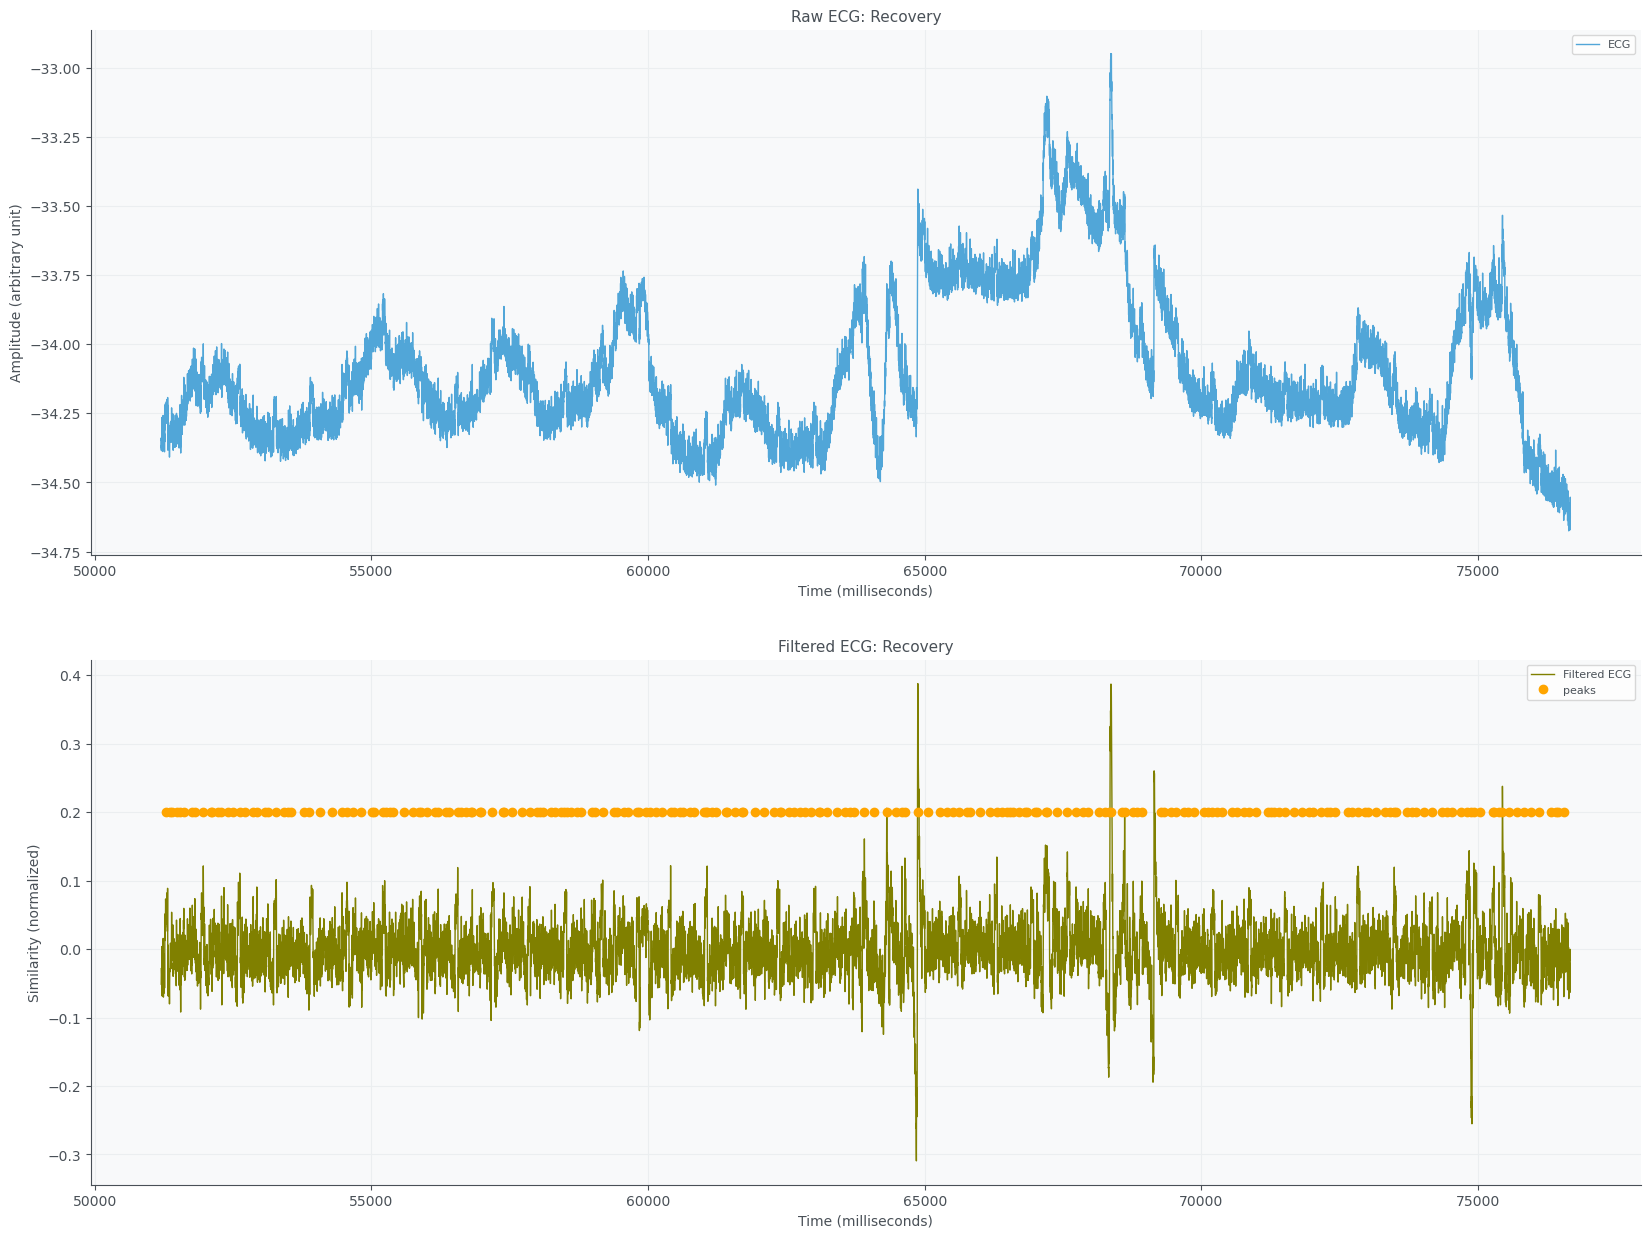

25600_51200_0_25600_Recovery1.png
negative
BASELINE DATA
0
25600


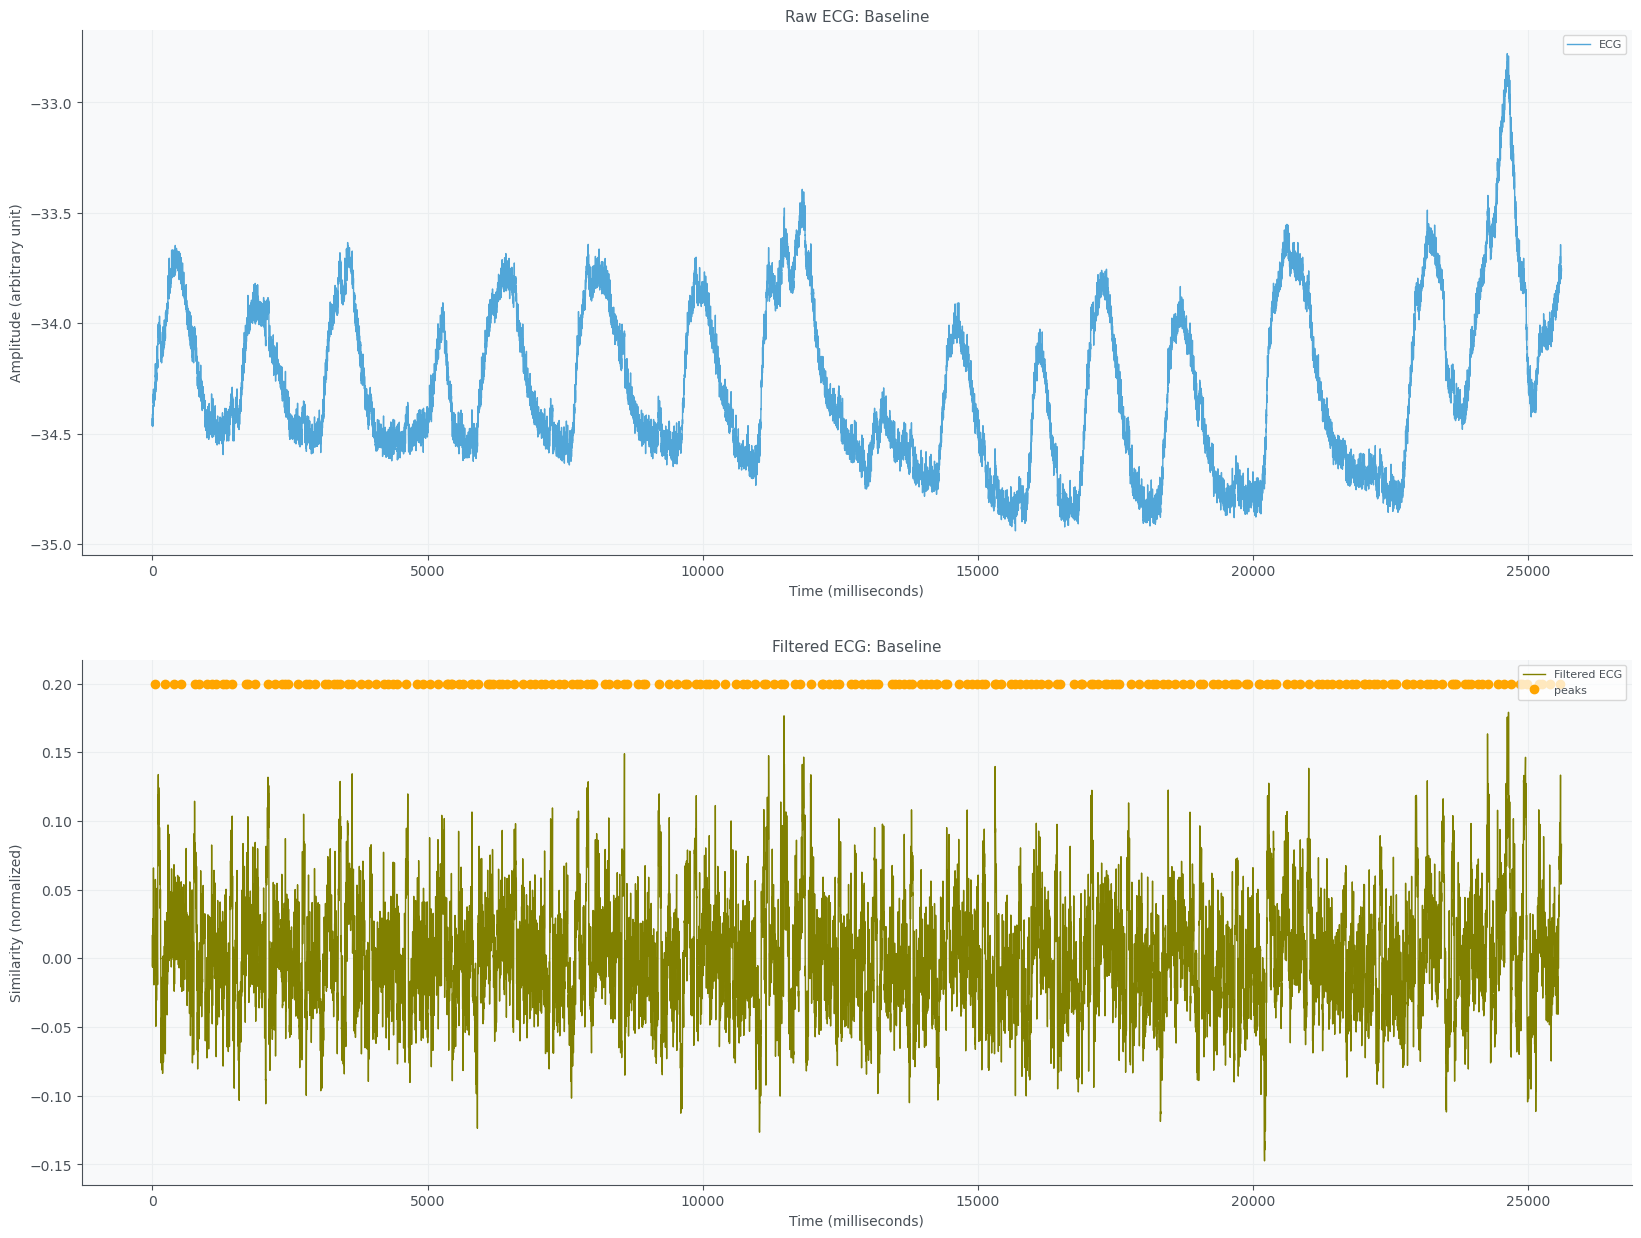

Baseline2.svg
25600
51200


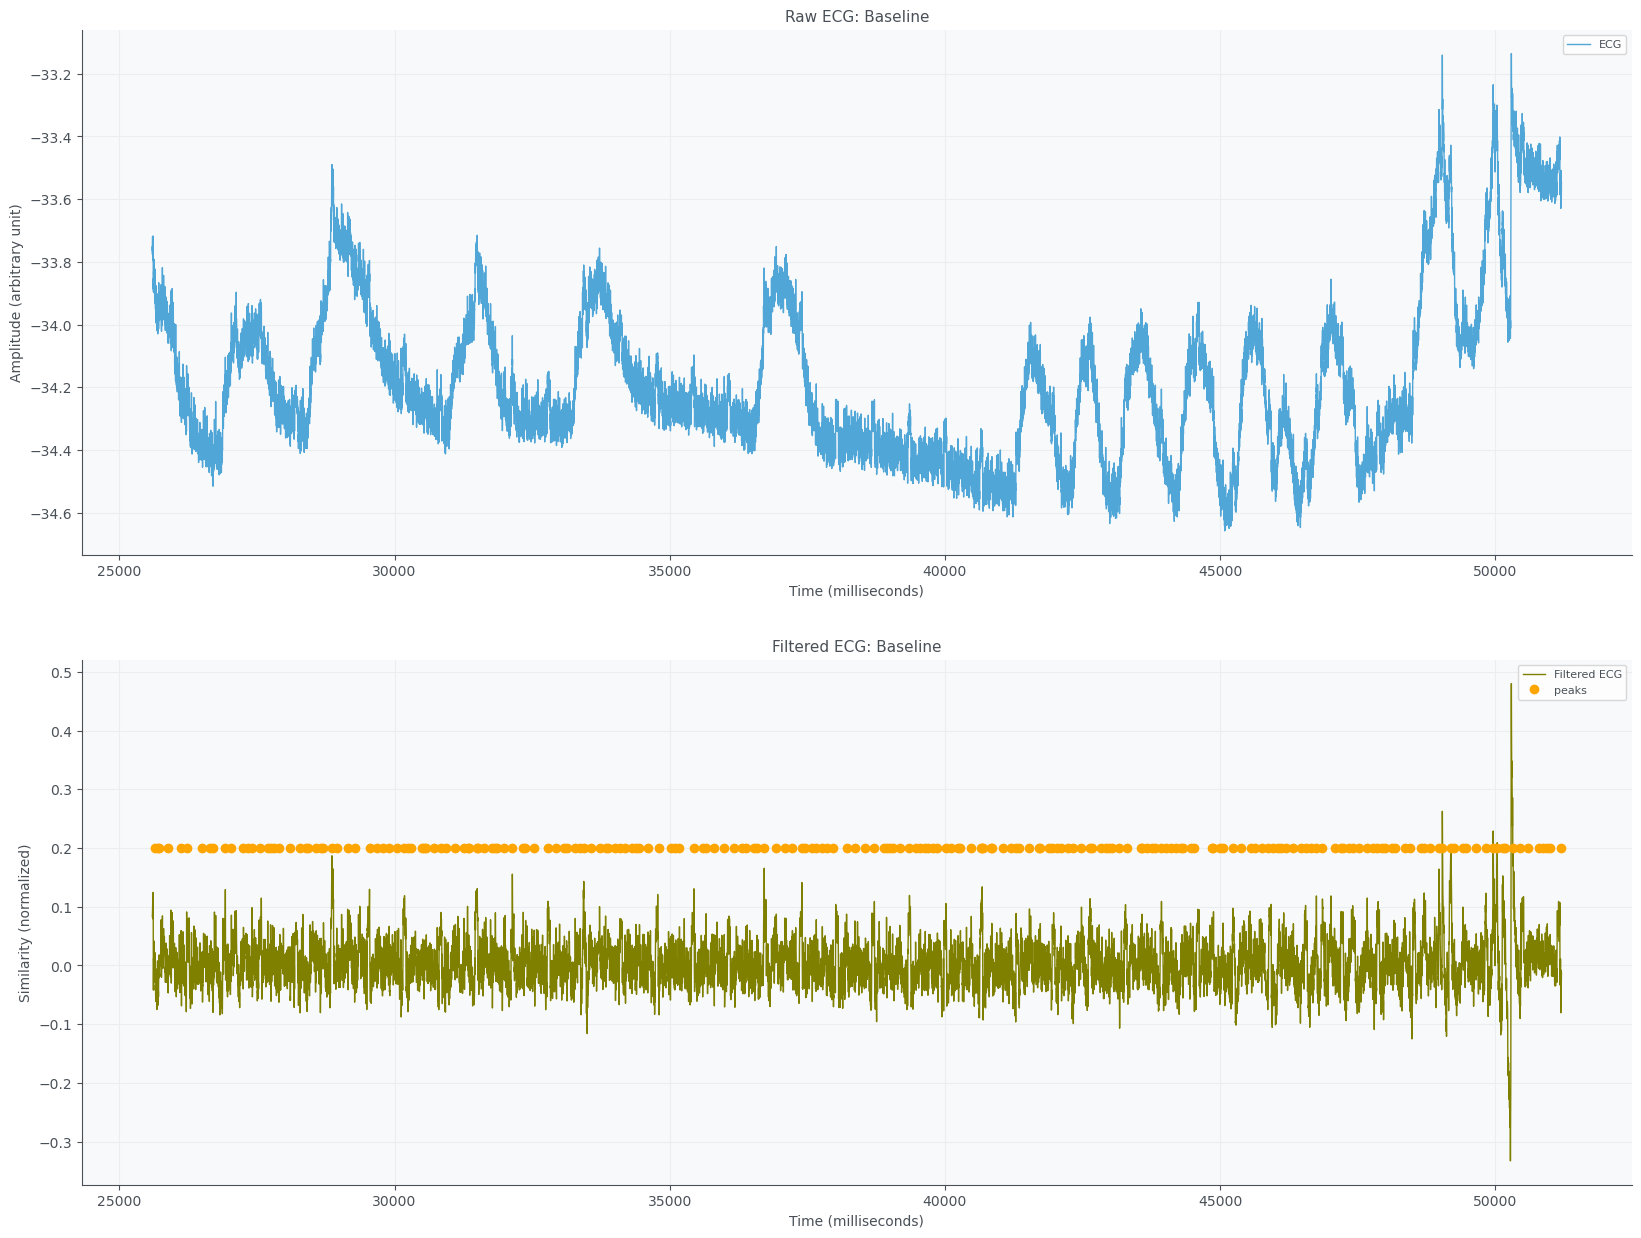

0_25600_Baseline2.svg
51200
76800


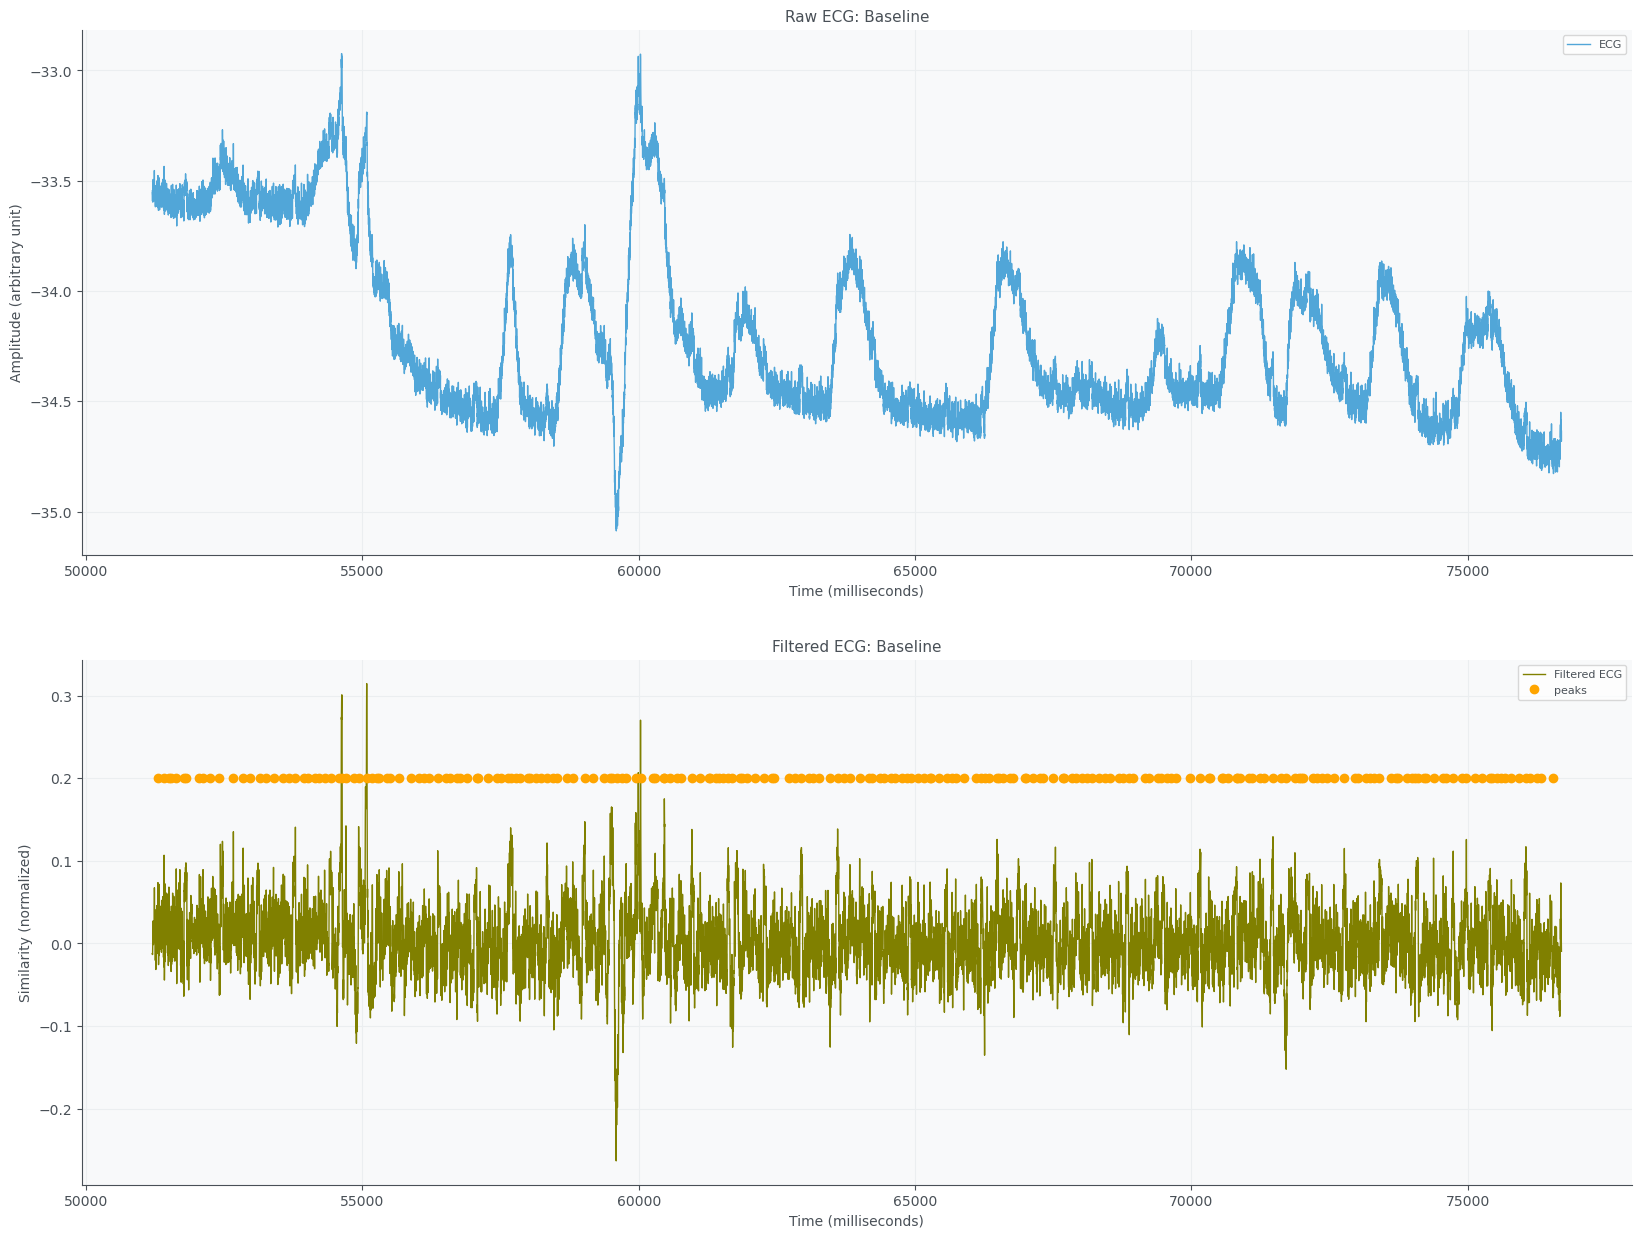

25600_51200_0_25600_Baseline2.svg
baseline start time: 2023-09-19 11:42:07.445258+02:00
baseline stop time: 2023-09-19 11:47:07.445258+02:00
shimmer_baseline start time: 2023-09-19 11:42:07.449127+02:00
shimmer_baseline stop time: 2023-09-19 11:47:07.445221+02:00
TASK DATA
0
25600


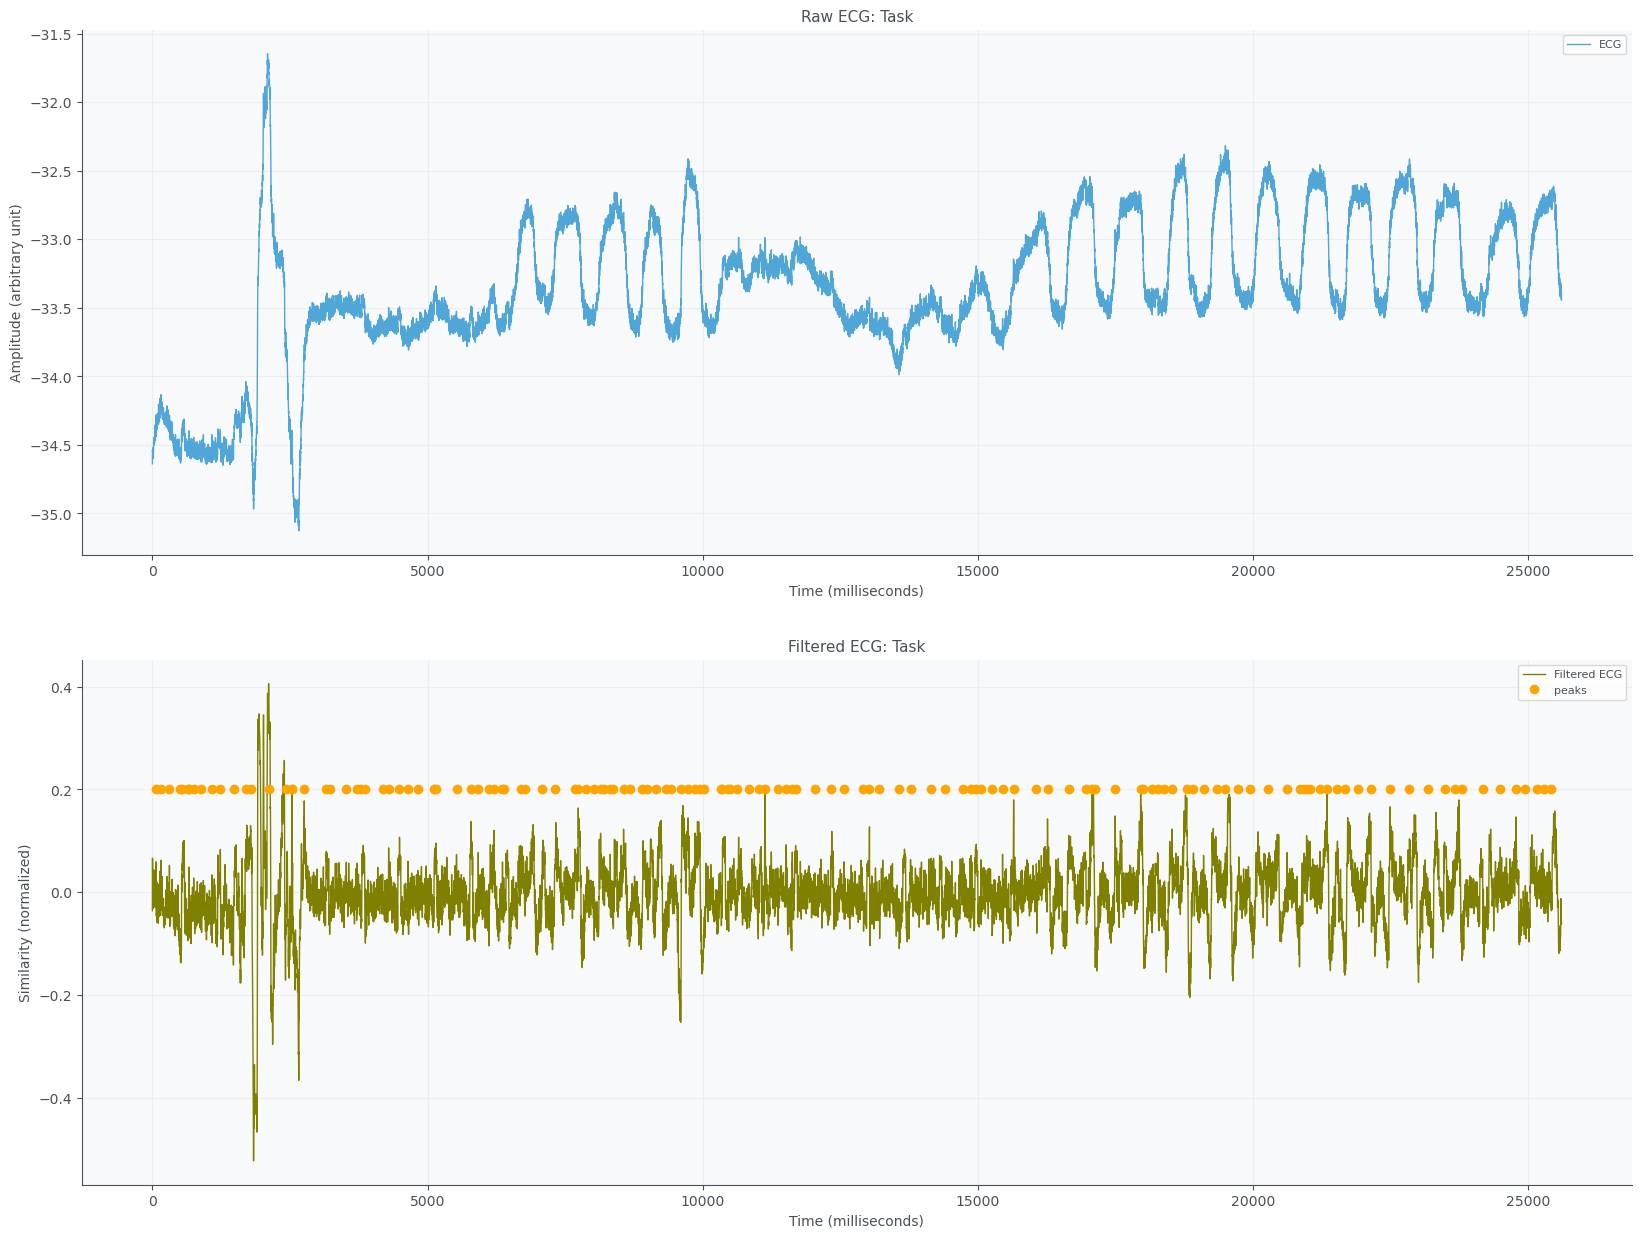

Task2.png
25600
51200


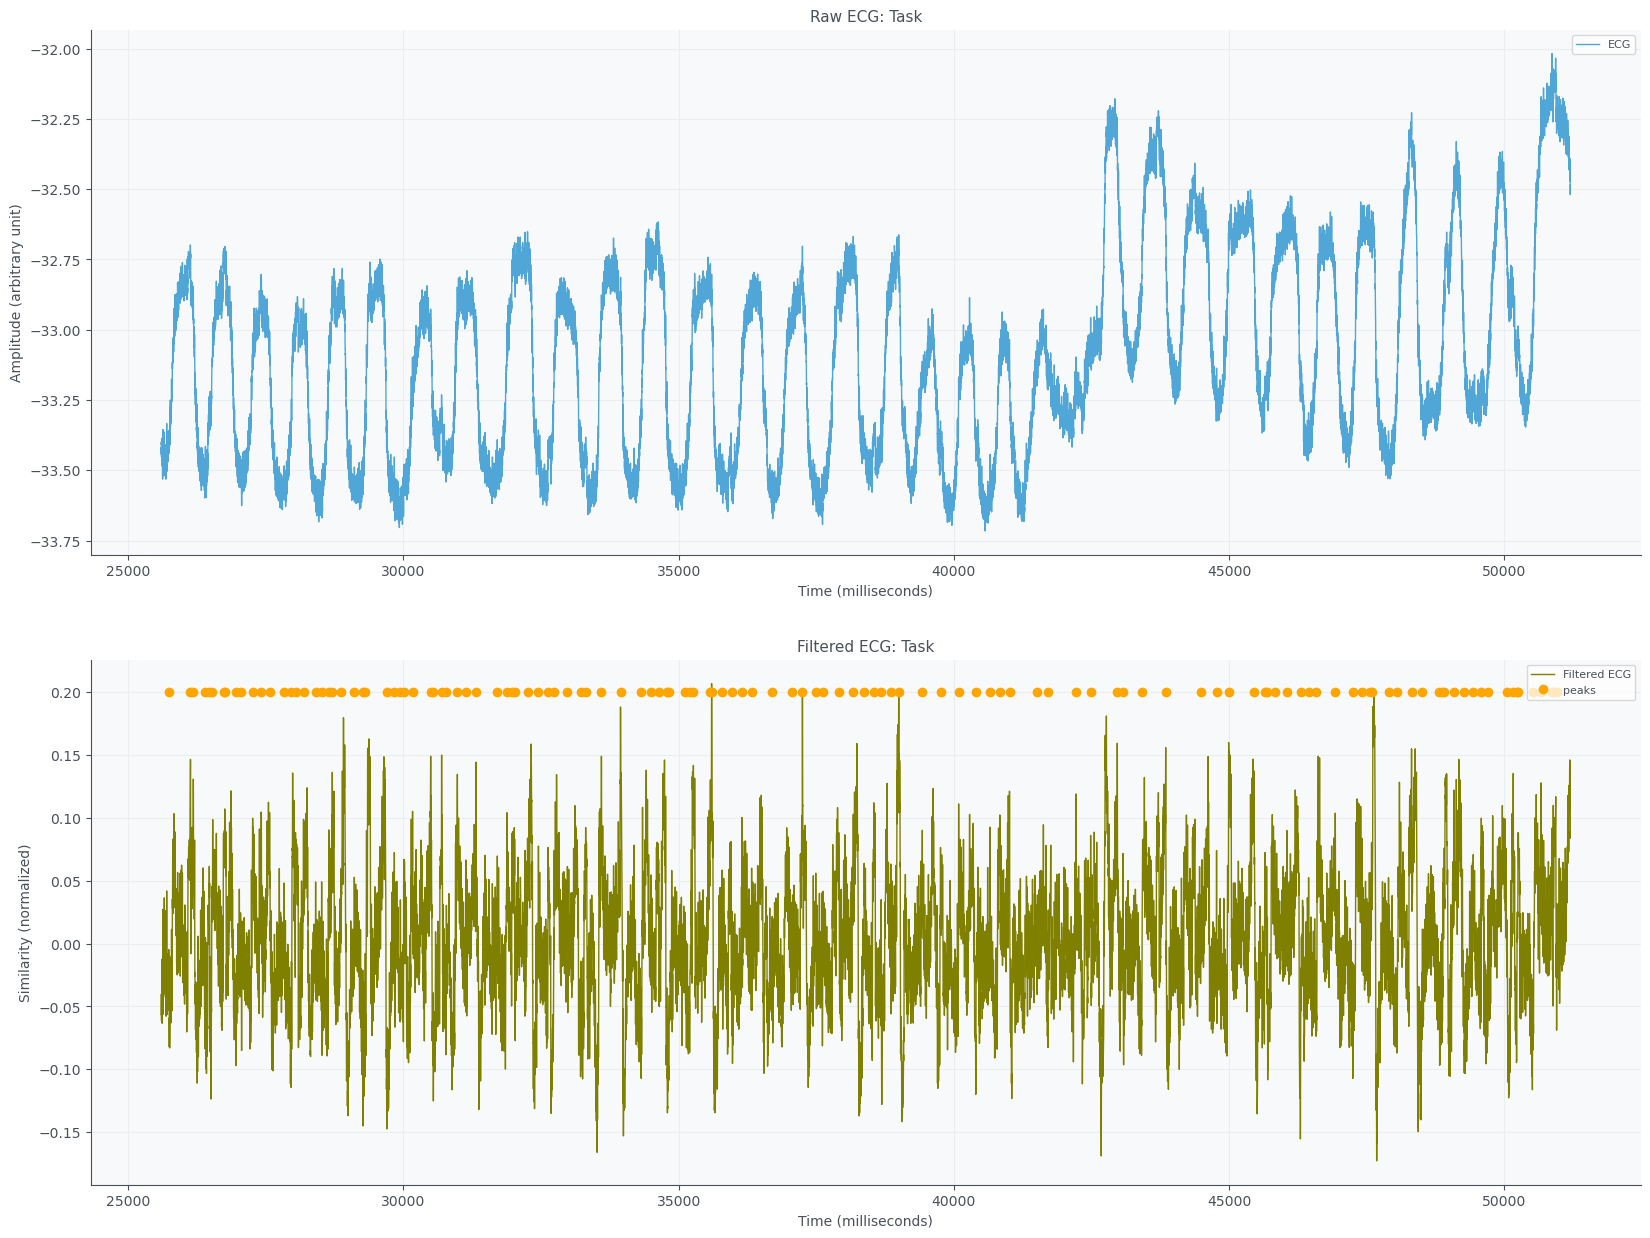

0_25600_Task2.png
51200
76800


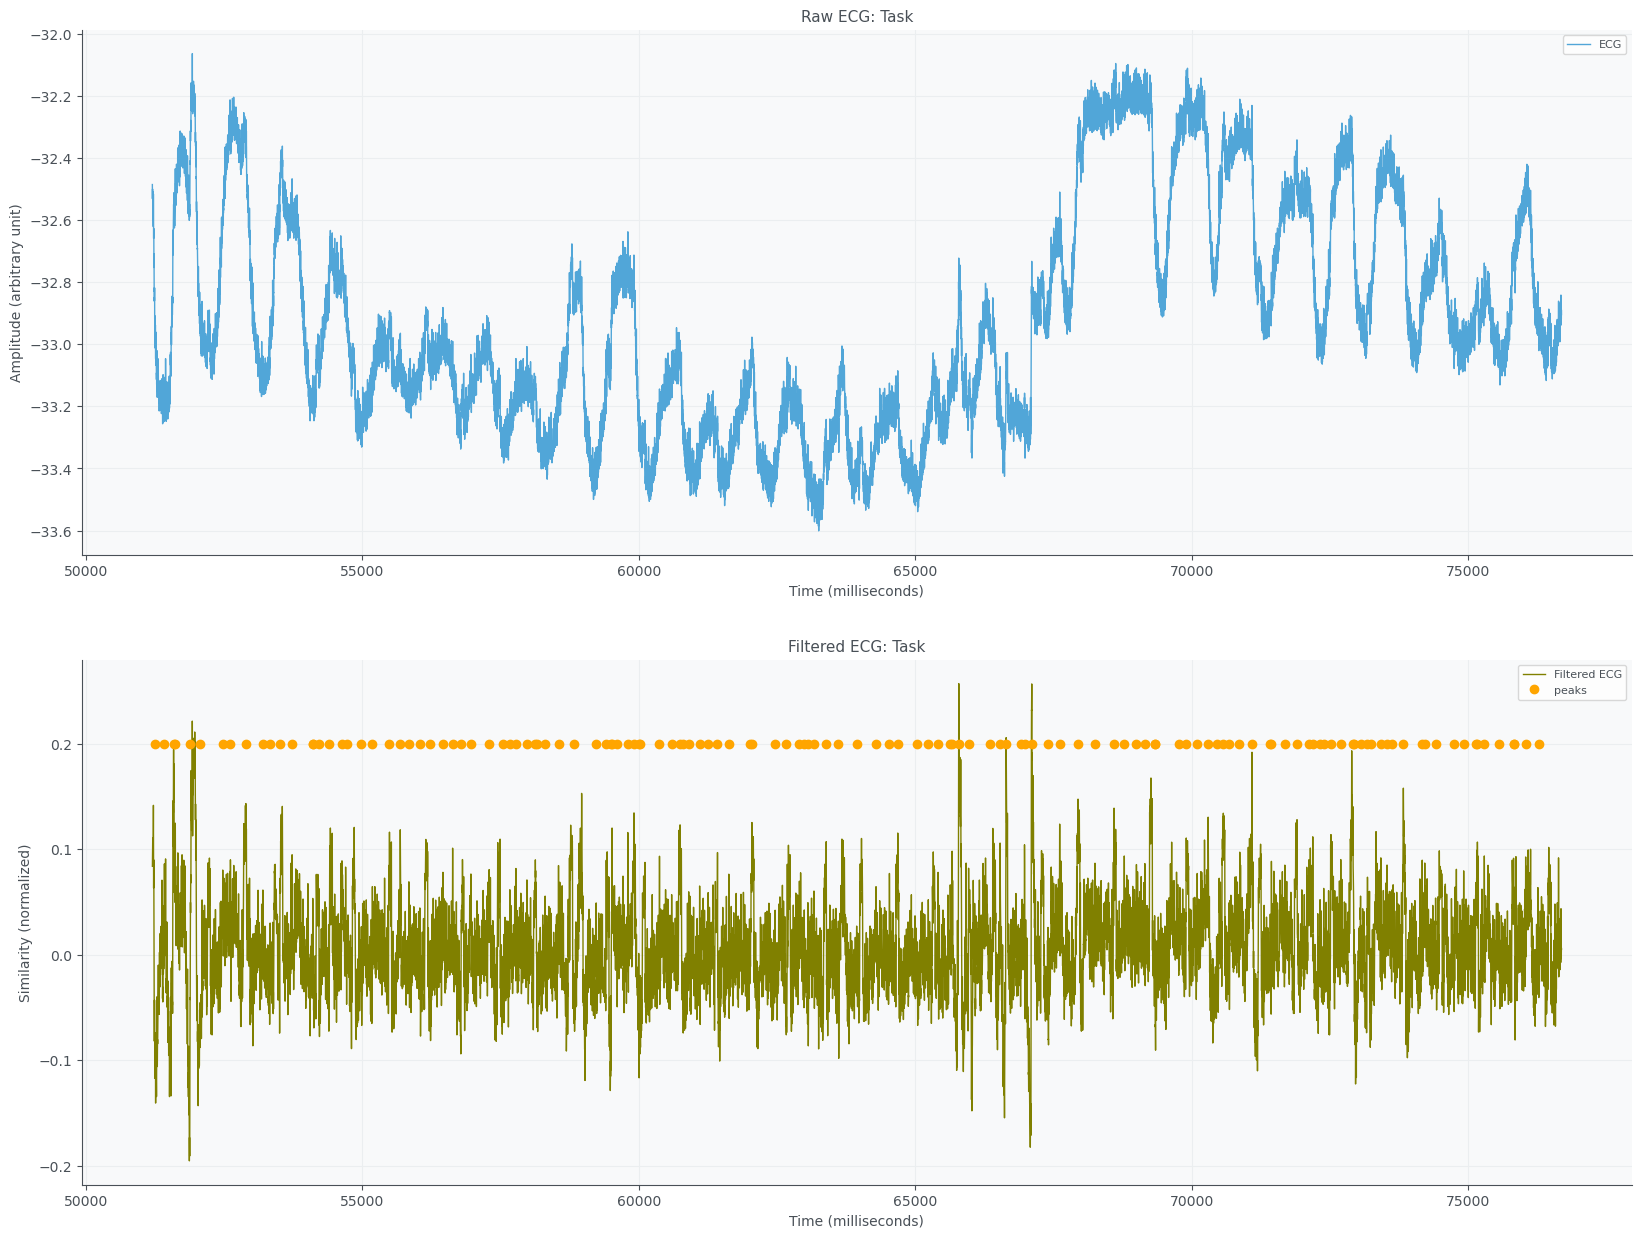

25600_51200_0_25600_Task2.png
task start time: 2023-09-19 11:47:07.847050+02:00
task stop time: 2023-09-19 11:52:07.847050+02:00
shimmer_task start time: 2023-09-19 11:47:07.847565+02:00
shimmer_task stop time: 2023-09-19 11:52:07.843658+02:00
recovery start time: 2023-09-19 11:52:09.614045+02:00
recovery stop time: 2023-09-19 11:57:09.614045+02:00
shimmer_recovery start time: 2023-09-19 11:52:09.617096+02:00
shimmer_recovery stop time: 2023-09-19 11:57:09.613190+02:00
psychopy_events_triggers_WP2_03_VEOQ_negative.pkl


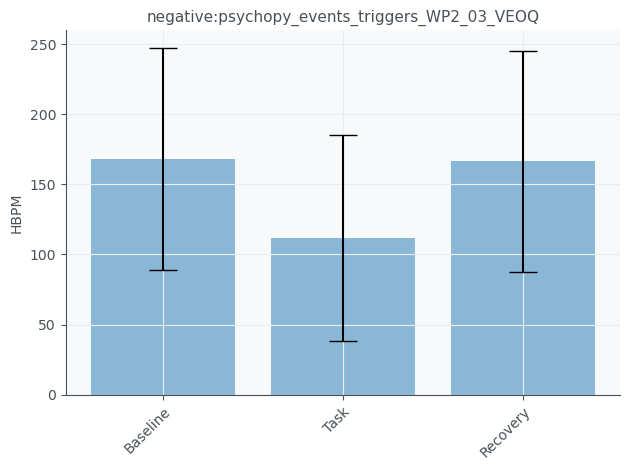

RECOVERY DATA
0
25600


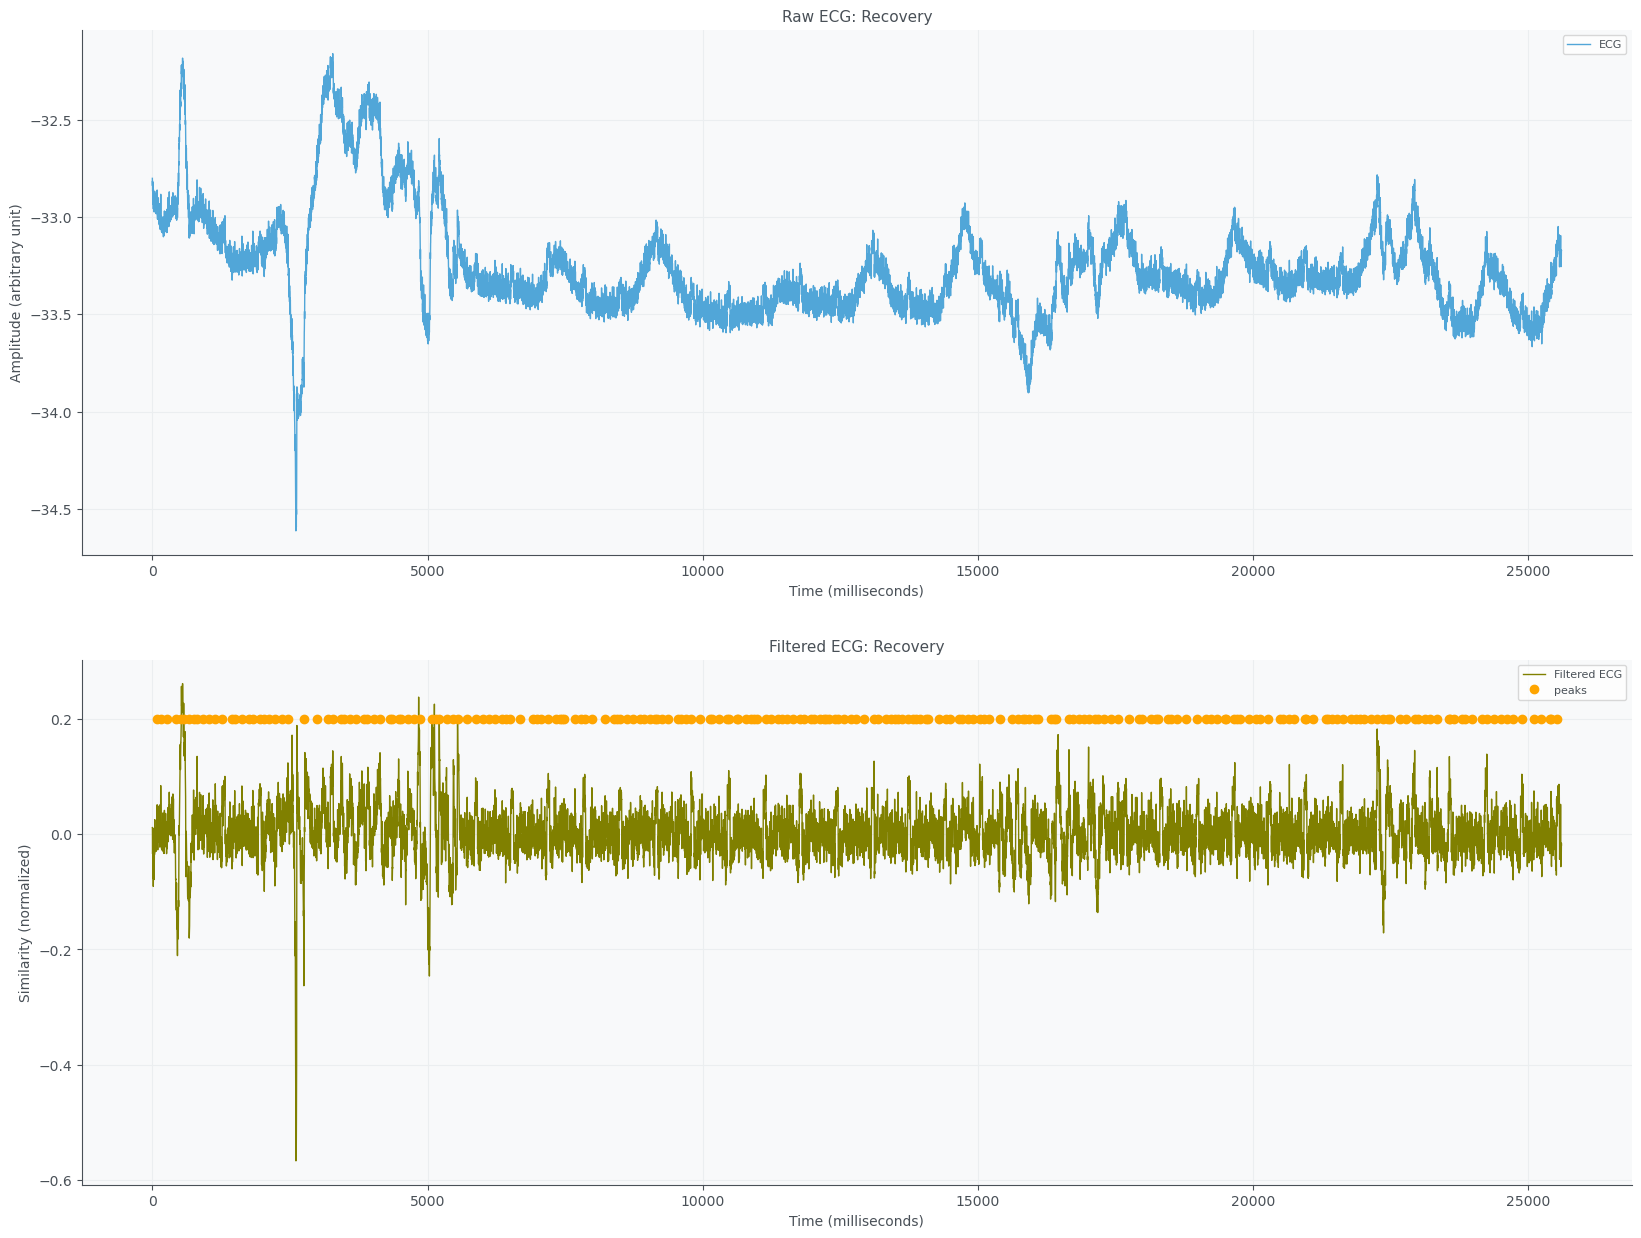

Recovery2.png
25600
51200


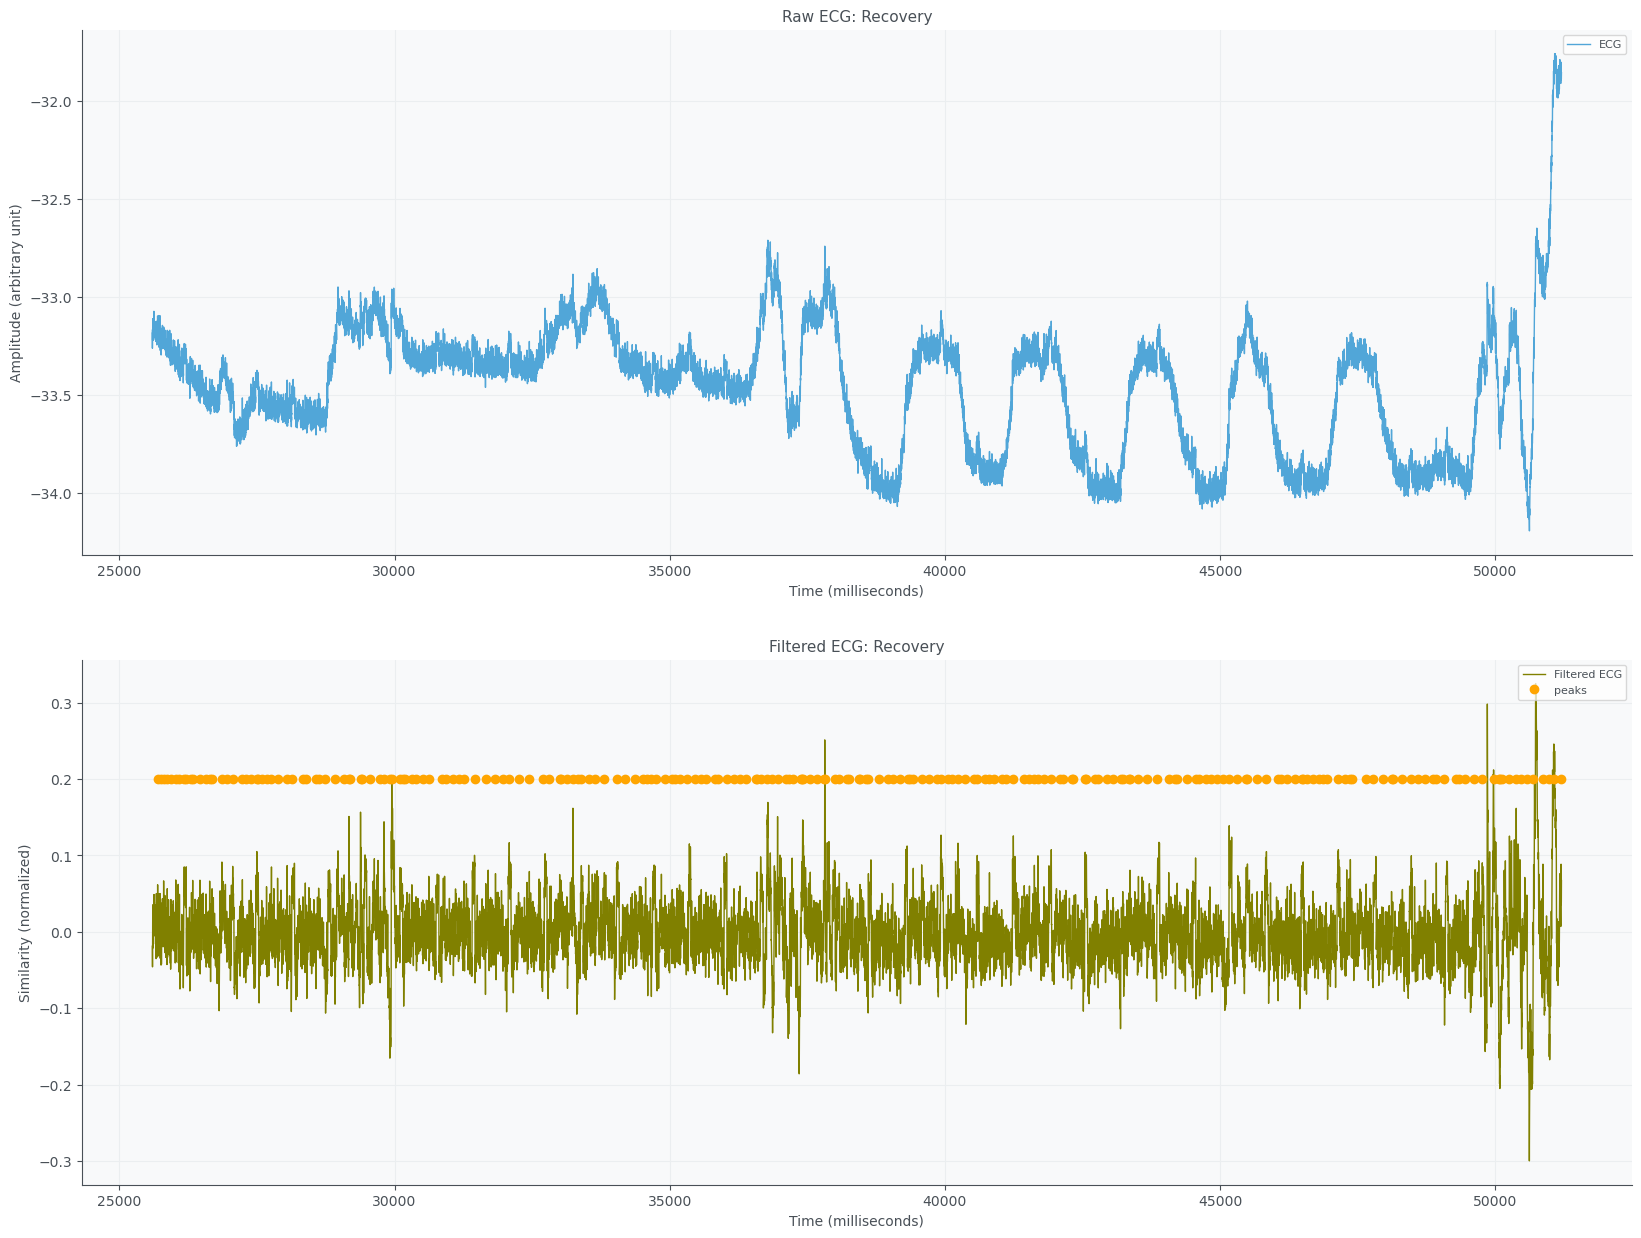

0_25600_Recovery2.png
51200
76800


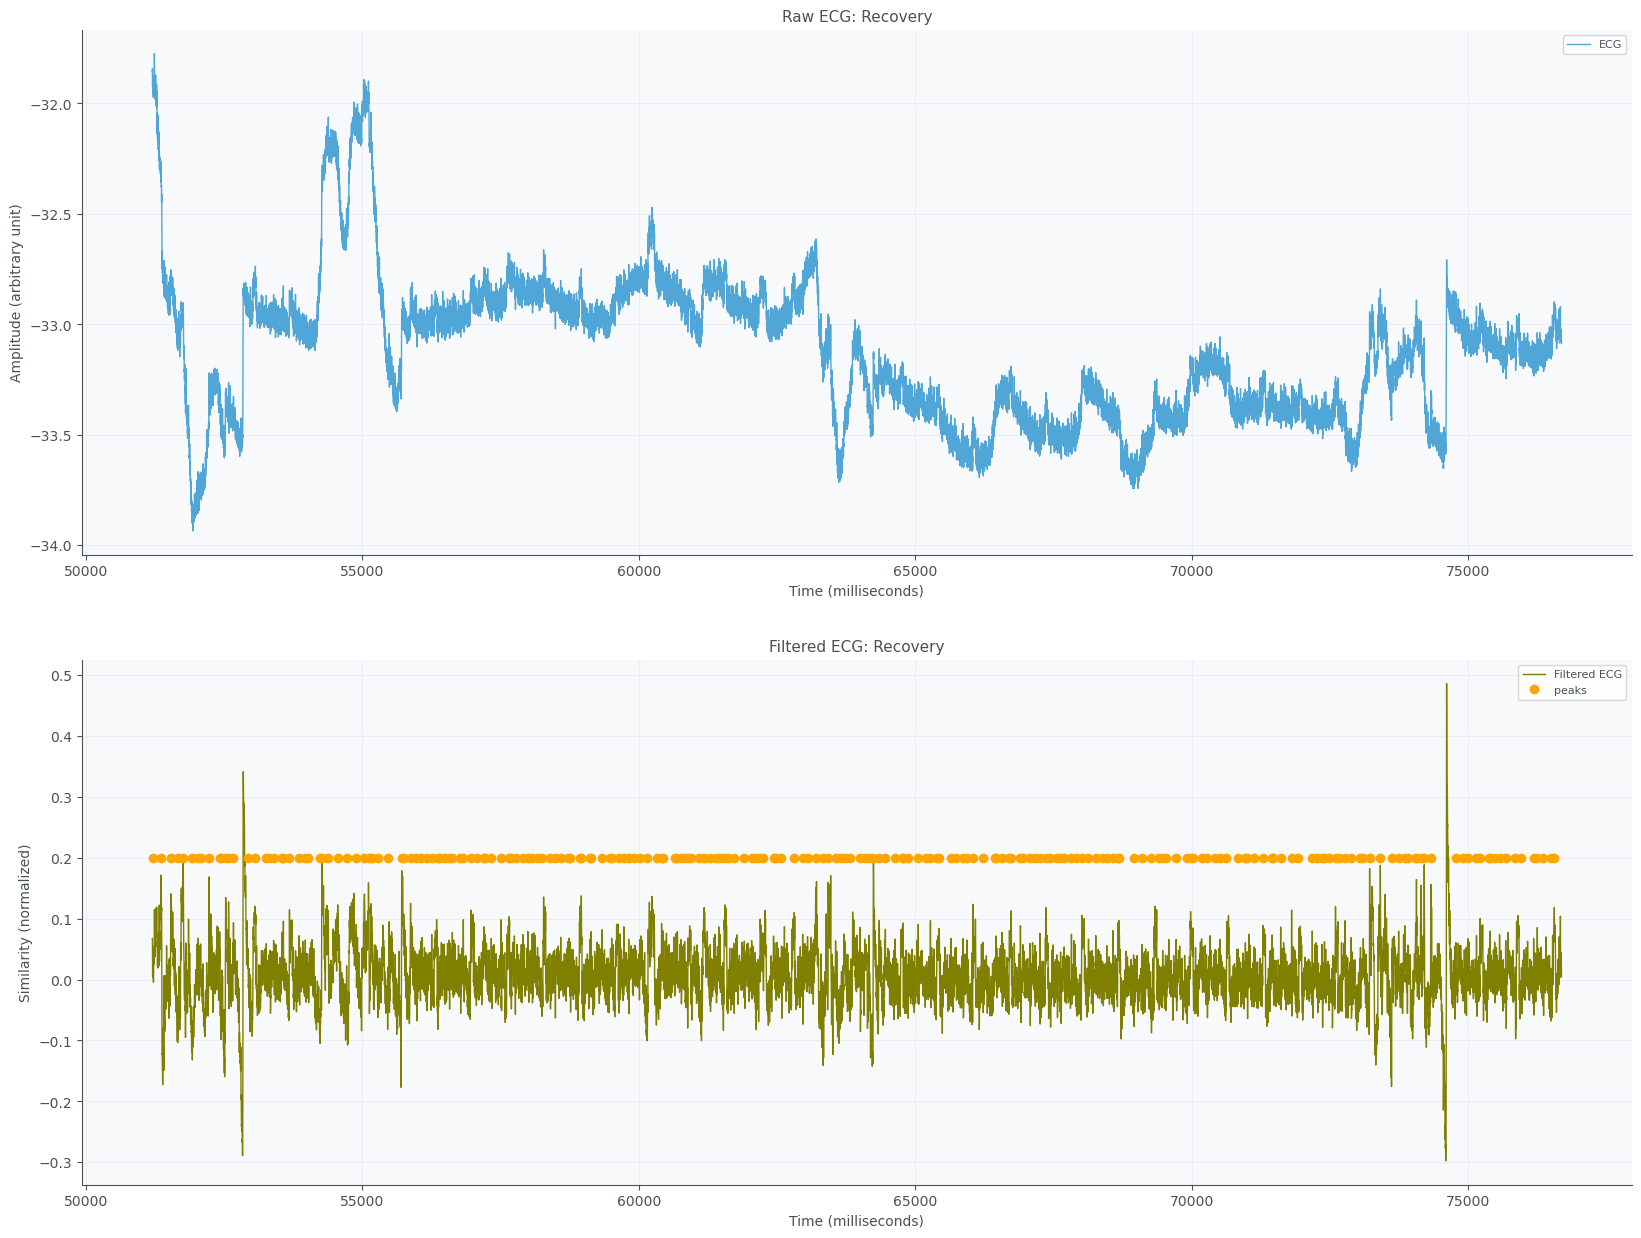

25600_51200_0_25600_Recovery2.png


In [45]:
sampling_freq_shimmer = 256
offset_min = 5
time_zone = 'Europe/Berlin'
tz = pytz.timezone(time_zone)

for sub_dir in sub_dirs:
    ###-----------------------------------------------
    #### reading psychopy, events, shimmer files
    ##----------------------------------------------
    
    sub_dir_path= os.path.join(data_dir_path, sub_dir)
    psychopy_file_path = os.path.join(sub_dir_path, "Psychopy")
    psychopy_file_path = glob.glob(psychopy_file_path+ "/*.csv")[0]
    #print(psychopy_file_path)
    events_path_list = os.path.join(sub_dir_path, "preAnalysis")
    events_path_list = glob.glob(events_path_list+ "/*.csv")
    
    for sel_event_path in events_path_list:
        fol_path, file_name_ii=os.path.split(sel_event_path)
        #print(file_name_ii)
        if "trigger" in file_name_ii:
            sel_trigger_file = sel_event_path
            
            fol_path_tri, file_name_trig=os.path.split(sel_trigger_file)
            
            print(file_name_trig)
            
    shimmer_files_subdir = os.path.join(sub_dir_path, "Shimmer")
    shimmer_files_subdir_subdir_name = next(os.walk(shimmer_files_subdir))[1][0]
    shimmer_files_parent_path = os.path.join(shimmer_files_subdir, shimmer_files_subdir_subdir_name)
    shimmer_files_name = glob.glob(shimmer_files_parent_path+ "/*.csv")
    
    for sh_file in shimmer_files_name:
        
        if '_8943_' in sh_file:
            ecg_shimmer_path = sh_file
            shimmer_timestamp_col_name = "Shimmer_8943_Timestamp_Unix_CAL"
            ecg_col_name = "Shimmer_8943_ECG_LA-RA_24BIT_CAL"
        elif "_8108_" in sh_file:
            ecg_shimmer_path=sh_file
            shimmer_timestamp_col_name = "Shimmer_8108_Timestamp_Unix_CAL"
            ecg_col_name = "Shimmer_8108_ECG_LA-RA_24BIT_CAL"
            
            
            
            
            
            
    psychopy_df = pd.read_csv(psychopy_file_path)
    block_1_type = psychopy_df["block1"][0]
    #print(block_1_type)
    
    event_timestamps_df = pd.read_csv(sel_trigger_file)
    
    baseline_onset = event_timestamps_df["baseline_onset"].values
    baseline_onset_timestamps = baseline_onset[1:]
    task_onset =event_timestamps_df["task_onset"].values
    task_onset_str_timestamps = task_onset[1:]
    task_onset_float_timestamp = from_str_to_float(task_onset_str_timestamps)
    recovery_onset =event_timestamps_df["recovery_onset"].values
    recovery_onset_str_timestamps = recovery_onset[1:]
    recovery_onset_list_timestamps=from_str_to_float(recovery_onset_str_timestamps)
    
    
    shimmer_df=read_shimmer_sensor(ecg_shimmer_path)
    
    selected_ecg_df = shimmer_df[[shimmer_timestamp_col_name, ecg_col_name]]
    selected_ecg_df = selected_ecg_df.copy()
    selected_ecg_df=standardize_timestamps_shimmer(selected_ecg_df, shimmer_timestamp_col_name)
    selected_ecg_df['ecg'] = selected_ecg_df[ecg_col_name]
    selected_ecg_df=col_from_str_float(selected_ecg_df, "ecg")
    
    ###-------------------------------------------------------
    ####-----------------------------------------------------
    ###-------------------------------------------------------
    
    #all_ibi_one_list_one_task = []
    #all_ibi_sublist_one_task = []
    
    
    for ind_timestamp, sel_baseline in enumerate(baseline_onset_timestamps):
        task_type_list = []
        all_ibi_one_list_one_task = []
        all_ibi_sublist_one_task = []
        mean_cumm_list = []
        std_cumm_list = []
        
        mean_hbpm_cumm_list = []
        std_hbpm_cumm_list = []
        
        if ind_timestamp==0:
            task_type_ii = "pre_assesment"
        
        elif ind_timestamp==1:
            if block_1_type=="negative":
                task_type_ii = "negative"
            elif block_1_type =="positive":
                task_type_ii = "positive"
        
        elif ind_timestamp==2:
            if block_1_type=="positive":
                task_type_ii = "negative"
            elif block_1_type =="negative":
                task_type_ii = "positive"
                
        #elif ind_timestamp==2:
        #    if block_1_type=="negative":
        #       task_type_ii = "positive"
        #    elif block_1_type =="positive":
        #        task_type_ii = "negative"
                
        print(task_type_ii)
        task_type_list.append(task_type_ii)           
        start_timestamp_baseline = sel_baseline
        stop_timestamp_baseline = get_offset_timestamp(start_timestamp_baseline, offset_min)


        sliced_ecg_df_baseline=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp_baseline, stop_timestamp_baseline, shimmer_timestamp_col_name)
        sliced_ecg_df_baseline=sliced_ecg_df_baseline.reset_index(drop=True)
        ecg_array_baseline = sliced_ecg_df_baseline["ecg"].values
        out_baseline = ecg.ecg(signal=ecg_array_baseline, sampling_rate=sampling_freq_shimmer, show=False, interactive=False)
        sliced_ecg_df_baseline["filtered"] = out_baseline["filtered"]
        r_peaks_ind_baseline = out_baseline["rpeaks"]
        rr_msec_baseline=from_rr_ind_2_msec(r_peaks_ind_baseline)
        rr_msec_baseline_clean=remove_outliers_rri(rr_msec_baseline, sampling_freq = 256, outlier_std = 1.5)
        
        time_domain_features=timedomain(rr_msec_baseline_clean)
        ###--------------------------------------------------
        mean_hbpm_baseline = time_domain_features["Mean HR (beats/min)"]
        std_hbpm_baseline = time_domain_features["STD HR (beats/min)"]
        
        
        
        all_ibi_one_list_one_task.extend(rr_msec_baseline_clean)
        all_ibi_sublist_one_task.append(rr_msec_baseline_clean)
        #mean_ibi = np.mean(rr_msec_baseline_clean)
        mean_cumm_list.append(np.mean(rr_msec_baseline_clean))
        std_cumm_list.append(np.std(rr_msec_baseline_clean))
        
        mean_hbpm_cumm_list.append(mean_hbpm_baseline)
        std_hbpm_cumm_list.append(std_hbpm_baseline)
    
        print("BASELINE DATA")
        sub_id = "sub_3"
        fig_name = "Baseline_"+ sub_id + ".svg"
        fig_name = "Baseline"+str(ind_timestamp)+".svg"
        plt_title_raw = "Raw ECG: Baseline"
        plt_title_filtered = "Filtered ECG: Baseline"
        total_plots = 3
        dest_path_save_figures = dest_path
        plot_ecg_wf(sliced_ecg_df_baseline,r_peaks_ind_baseline,offset_min,dest_path_save_figures, fig_name, nr_plots=total_plots, fig_title_raw=plt_title_raw, fig_title_filtered=plt_title_filtered)
    
    
    
        ####--------------------------------------------------------------------
        ####------------------for debugging purposes----------------------------
        ####--------------------------------------------------------------------
        start_time = dt.datetime.fromtimestamp(start_timestamp_baseline, tz)
        end_time  = dt.datetime.fromtimestamp(stop_timestamp_baseline, tz)

        print("baseline start time: "+str(start_time))
        print("baseline stop time: "+str(end_time))

        time_stamps_shimmer= sliced_ecg_df_baseline[shimmer_timestamp_col_name].values

        start_timestamp_shimmer = time_stamps_shimmer[0]
        end_timestamp_shimmer =  time_stamps_shimmer[-1]

        start_time = dt.datetime.fromtimestamp(start_timestamp_shimmer, tz)
        end_time  = dt.datetime.fromtimestamp(end_timestamp_shimmer, tz)

        print("shimmer_baseline start time: "+str(start_time))
        print("shimmer_baseline stop time: "+str(end_time))
    
        ####------------------------------------------------------------------

        start_timestamp_task= task_onset_float_timestamp[ind_timestamp]
        stop_timestamp_task = get_offset_timestamp(start_timestamp_task, offset_min)
        sliced_ecg_df_task=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp_task, stop_timestamp_task, shimmer_timestamp_col_name)
        sliced_ecg_df_task=sliced_ecg_df_task.reset_index(drop=True)
        ###-------------------------------------------------
        ecg_array_task = sliced_ecg_df_task["ecg"].values
        out_task = ecg.ecg(signal=ecg_array_task, sampling_rate=sampling_freq_shimmer, show=False, interactive=False)
        sliced_ecg_df_task["filtered"] = out_task["filtered"]
        r_peaks_ind_task = out_task["rpeaks"]
        rr_msec_task=from_rr_ind_2_msec(r_peaks_ind_task)
        rr_msec_task_clean=remove_outliers_rri(rr_msec_task, sampling_freq = 256, outlier_std = 1.5)
        
        time_domain_features=timedomain(rr_msec_task_clean)
        ###--------------------------------------------------
        mean_hbpm_task = time_domain_features["Mean HR (beats/min)"]
        std_hbpm_task = time_domain_features["STD HR (beats/min)"]
        
        all_ibi_one_list_one_task.extend(rr_msec_task_clean)
        all_ibi_sublist_one_task.append(rr_msec_task_clean)
        
        mean_cumm_list.append(np.mean(rr_msec_task_clean))
        std_cumm_list.append(np.std(rr_msec_task_clean))
        
        mean_hbpm_cumm_list.append(mean_hbpm_task)
        std_hbpm_cumm_list.append(std_hbpm_task)
        
        print("TASK DATA")
        fig_name = "Task"+ sub_id + ".png"
        fig_name = "Task"+str(ind_timestamp)+".png"
        plt_title_raw = "Raw ECG: Task"
        plt_title_filtered = "Filtered ECG: Task"
        
        plot_ecg_wf(sliced_ecg_df_task,r_peaks_ind_task,offset_min, dest_path_save_figures,fig_name, 
                    nr_plots=total_plots, fig_title_raw=plt_title_raw, fig_title_filtered=plt_title_filtered)
    
        #####------------------------------------------------------------
        ##### -------------for debugging---------------------------------
        #####------------------------------------------------------------

        start_time = dt.datetime.fromtimestamp(start_timestamp_task, tz)
        end_time  = dt.datetime.fromtimestamp(stop_timestamp_task, tz)

        print("task start time: "+str(start_time))
        print("task stop time: "+str(end_time))

        time_stamps_shimmer= sliced_ecg_df_task[shimmer_timestamp_col_name].values

        start_timestamp_shimmer = time_stamps_shimmer[0]
        end_timestamp_shimmer =  time_stamps_shimmer[-1]

        start_time = dt.datetime.fromtimestamp(start_timestamp_shimmer, tz)
        end_time  = dt.datetime.fromtimestamp(end_timestamp_shimmer, tz)

        print("shimmer_task start time: "+str(start_time))
        print("shimmer_task stop time: "+str(end_time))

        ####-------------------------------------------------------------
        ####-------------------------------------------------------------
        ####-------------------------------------------------------------
    
        start_timestamp_recovery= recovery_onset_list_timestamps[ind_timestamp]
        stop_timestamp_recovery =get_offset_timestamp(start_timestamp_recovery, offset_min)
        sliced_ecg_df_recovery=slice_df_wrt_timestamps(selected_ecg_df, start_timestamp_recovery, stop_timestamp_recovery, shimmer_timestamp_col_name)
        sliced_ecg_df_recovery=sliced_ecg_df_recovery.reset_index(drop=True)

        ###-------------------------------------------------
        ecg_array_recovery = sliced_ecg_df_recovery["ecg"].values
        out_recovery = ecg.ecg(signal=ecg_array_recovery, sampling_rate=sampling_freq_shimmer, show=False, interactive=False)
        sliced_ecg_df_recovery["filtered"] = out_recovery["filtered"]
        r_peaks_ind_recovery = out_recovery["rpeaks"]
        rr_msec_recovery=from_rr_ind_2_msec(r_peaks_ind_recovery)
        rr_msec_recovery_clean=remove_outliers_rri(rr_msec_recovery, sampling_freq = 256, outlier_std = 1.5)
        time_domain_features=timedomain(rr_msec_recovery_clean)
        ###--------------------------------------------------
        mean_hbpm_recovery = time_domain_features["Mean HR (beats/min)"]
        std_hbpm_recovery = time_domain_features["STD HR (beats/min)"]
        ###-----------------------------------------------------
        all_ibi_one_list_one_task.extend(rr_msec_task_clean)
        all_ibi_sublist_one_task.append(rr_msec_task_clean)
        mean_cumm_list.append(np.mean(rr_msec_recovery_clean))
        std_cumm_list.append(np.std(rr_msec_recovery_clean))
        
        mean_hbpm_cumm_list.append(mean_hbpm_recovery)
        std_hbpm_cumm_list.append(std_hbpm_recovery)
        
        
        #####------------------------------------------------------------
        ##### -------------for debugging---------------------------------
        #####------------------------------------------------------------
        start_time = dt.datetime.fromtimestamp(start_timestamp_recovery, tz)
        end_time  = dt.datetime.fromtimestamp(stop_timestamp_recovery, tz)

        print("recovery start time: "+str(start_time))
        print("recovery stop time: "+str(end_time))


        time_stamps_shimmer= sliced_ecg_df_recovery[shimmer_timestamp_col_name].values

        start_timestamp_shimmer = time_stamps_shimmer[0]
        end_timestamp_shimmer =  time_stamps_shimmer[-1]

        start_time = dt.datetime.fromtimestamp(start_timestamp_shimmer, tz)
        end_time  = dt.datetime.fromtimestamp(end_timestamp_shimmer, tz)

        print("shimmer_recovery start time: "+str(start_time))
        print("shimmer_recovery stop time: "+str(end_time))

        ####-------------------------------------------------------------
        ####-------------------------------------------------------------
        ####-------------------------------------------------------------
        
        
        hrv_data_dict = {}
        
        hrv_data_dict["subject_id"] = file_name_ii
        
        event_interets_plot = ["Baseline", "Task", "Recovery"]
    
        hrv_data_dict["event_interst"] = event_interets_plot
    
        hrv_data_dict["all_rr_one_list"] = all_ibi_one_list_one_task
    
        hrv_data_dict["all_rr_sublists"] = all_ibi_sublist_one_task
        
        hrv_data_dict["mean_hbpm"] = mean_hbpm_cumm_list
        hrv_data_dict["std_hbpmy"] = std_hbpm_cumm_list
        
        hrv_data_dict["mean_ibi"] = mean_cumm_list
        hrv_data_dict["std_ibi"] = std_cumm_list
        
        hrv_data_dict["task_type"] = task_type_ii
        
        
        pkl_file_hrv = file_name_trig[:-4] + "_"+task_type_ii+ ".pkl"
        
        print(pkl_file_hrv)
        
        dest_path_pkl_file = os.path.join(dest_path, pkl_file_hrv)
        with open(dest_path_pkl_file, "wb") as f:
            pickle.dump(hrv_data_dict, f)
            f.close()
            
        title_fig =  task_type_ii+ ":" + file_name_trig[:-4]
        fig_name =  file_name_trig[:-4]+ "_" + task_type_ii+".png"
        fig_dest_path = os.path.join(dest_path,fig_name)
        y_label_fig = "HBPM"
        fig_mean_std= plot_mean_std(mean_hbpm_cumm_list, std_hbpm_cumm_list, event_interets_plot, title_fig, y_label_fig)
        
        fig_mean_std.savefig(fig_dest_path)
        
        
        
        #mean_norm_list, std_norm_list = min_max_norm(all_ibi_one_list_one_task, all_ibi_sublist_one_task)
        
        #title_fig =  file_name_ii[:-4] + task_type_ii 
        #y_label_fig = "Norm-IBI"
        #fig_norm_mean_std= plot_mean_std(mean_norm_list, std_norm_list, event_interets_plot, title_fig, y_label_fig)
        
        
        
    
        ###-------------------------------------------------------------------
        ####-------------------for raw and filtered plotting-------------------
        ####-------------------------------------------------------------------
        print("RECOVERY DATA")
        fig_name="Recovery_"+ sub_id + ".png"
        fig_name = "Recovery"+str(ind_timestamp)+".png"
        plt_title_raw = "Raw ECG: Recovery"
        plt_title_filtered = "Filtered ECG: Recovery"
        plot_ecg_wf(sliced_ecg_df_recovery,r_peaks_ind_recovery,offset_min, dest_path_save_figures, 
                    fig_name, nr_plots=total_plots, fig_title_raw=plt_title_raw, fig_title_filtered=plt_title_filtered )

        ####-------------------------------------------------------------------------
    
    
    
    
    
    

        